In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

In [2]:
### Define parameters ###
# [version] is the SEVN2 version adopted                            e.g. '3.0.0-Spindevel_RLO'
# [Nsim] is the number of simulations                               e.g. '1mln'
# [Z] is the metallicity of the stars                               e.g. '02' for Z=0.02 solar metallicity
# [SN] is the SN explosion prescription adopted                     e.g. 'del' for delayed or 'com' for compact
# [n] number of cores involved in dask computation                  e.g.  4
# [Hsup] is the threshold for spectroscopic WR                      e.g. '0.3' for WR with H < 0.3 on surface
# [thres_RL] is the threshold for Roche Lobe filling binaries
# [thres_wind] is the threshold for wind fed binaries


Nsim,Z,SN,kick= '1mln','015', 'rap','hobbs265'                     # to select a set of simulations
ppisn = 'without'
version = '3.0.0-Spindevel_RLO'                                      # select SEVN2 version
path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
n = 4                                                                # cores for dask computation
Hsup,thres_RL,thres_wind = 0.3,1.,0.8                                # for functions inside WRBH_select.py
observed = ['cyg_x-3--Zd13', 'cyg_x-3--Ko17']                        # types of mass ranges

In [3]:
def removecol(df,colname):
    if colname in df.columns:
        df = df.drop(columns = [colname])
    return df

In [4]:
def Extract(dfname):
    # progenitors, remnants and initial and final istant of the selected WRBH type
    p = pd.read_csv(f'{path_results}/progenitors/p_{dfname}.csv')
    i = pd.read_csv(f'{path_results}/initial_WRBH/i_{dfname}.csv')
    f = pd.read_csv(f'{path_results}/final_WRBH/f_{dfname}.csv')
    r = pd.read_csv(f'{path_results}/remnants/r_{dfname}.csv')
    
    # remove NaNs
    i.fillna(-2, inplace=True)
    f.fillna(-2, inplace=True)
    
    # convert Period from yrs to days
    days_in_year = 365
    p.Period = p.Period*days_in_year
    i.Period = i.Period*days_in_year
    f.Period = f.Period*days_in_year
    r.Period = r.Period*days_in_year
    
    # remove extra columns
    colname = '_merge'
    p = removecol(p,colname)
    i = removecol(i,colname)
    f = removecol(f,colname)
    r = removecol(r,colname)
        

    return p,i,f,r

In [5]:
# extract dataframes
dfname1 = 'BHBH_GW_WRBH'
dfname2 = 'BHBH_GW_WRBH_cyg_x-3--Ko17'

pall,iall,fall,rall= Extract('BHBH_bound_WRBH')
p,i,f,r = Extract(dfname1)
p2,i2,f2,r2 = Extract(dfname2)

In [6]:
def RLOtype(dfname):
    # extract output with all timesteps re-simulated
    out = pd.read_csv(f'{path_results}/{dfname}/run_scripts/sevn_output/output_0.csv')
    
    # convert Period from yrs to days
    days_in_year = 365
    out.Period = out.Period*days_in_year
    
    # add RL filling columns
    out['RLfill0'] = out['Radius_0']/out['RL0']
    out['RLfill1'] = out['Radius_1']/out['RL1']

    # extract BEvent
    Bevent = out[(out.BEvent >= 4) & (out.BEvent<=15) ]
    #print(Bevent[['BWorldtime','BEvent','PhaseBSE_0','PhaseBSE_1']])
    
    ######################################################
    # pure STABLE RLO
    # select only events where a 4 is followed by a 5
    condRLOstablei = Bevent.BEvent.shift(-1).eq(5) & Bevent.BEvent.eq(4) # select 4
    condRLOstablef = Bevent.BEvent.shift().eq(4) & Bevent.BEvent.eq(5)   # select 5
    RLOstablei = Bevent[condRLOstablei].reset_index()
    RLOstablef = Bevent[condRLOstablef].reset_index()
    
    # STABLE RLO that ends up in a CE after some time
    # select only events where a 4 is followed by a 7
    condRLOstableCEi = Bevent.BEvent.shift(-1).eq(7) & Bevent.BEvent.eq(4) # select 4
    condRLOstableCEf = Bevent.BEvent.shift().eq(4) & Bevent.BEvent.eq(7)   # select 7
    RLOstableCEi = Bevent[condRLOstableCEi].reset_index()
    RLOstableCEf = Bevent[condRLOstableCEf].reset_index()
    
    ###############################################################
    Nstable = RLOstablei.name.value_counts().rename_axis('name').reset_index(name='Nstable')
    NstableCE = RLOstableCEi.name.value_counts().rename_axis('name').reset_index(name='NstableCE')
    RLOrecap = pd.merge(Nstable,NstableCE, how='outer', on='name').fillna(0)
    RLOrecap['Ntot'] = RLOrecap.Nstable + RLOrecap.NstableCE
    #print(RLOrecap)
    
    return out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap

In [7]:
def Filtername(df1,df2):
    # select only names of df1 that are in df2
    filtered = df1[df1.name.isin(df2.name.to_numpy())]
    return filtered

In [8]:
if ppisn!= 'only':
    dfname = dfname2
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
    deltaRLOstableCE = RLOstableCEf - RLOstableCEi
    deltaRLOstable = RLOstablef - RLOstablei

    i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
    i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
    i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

    # deltas of the first dataframes that undergo also the second condition
    delta_if2 = f2 - i2
    delta_if_if2 = f_f2 - i_i2
    delta_if_RLOstable = f_RLOstable - i_RLOstable
    delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
else:
    dfname=dfname1

delta_ifall = fall-iall
delta_if = f-i

# Plots

In [9]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})

In [10]:
def plotPhaseBSE(ax, xaxis,yaxis,phasebse, singledf,c, lw, z):
    ax.plot(singledf[singledf[phasebse] == 1.0][xaxis].values, singledf[singledf[phasebse] == 1.0][yaxis].values, color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 2.0][xaxis].values, singledf[singledf[phasebse] == 2.0][yaxis].values, color= c, linestyle = 'dashed', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 3.0][xaxis].values, singledf[singledf[phasebse] == 3.0][yaxis].values, color= c, linestyle = 'dotted', linewidth = lw, zorder = z)
    ax.scatter(singledf[singledf[phasebse] == 3.0][xaxis].values, singledf[singledf[phasebse] == 3.0][yaxis].values, c= 'k',s=100, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 4.0][xaxis].values, singledf[singledf[phasebse] == 4.0][yaxis].values,color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 5.0][xaxis].values, singledf[singledf[phasebse] == 5.0][yaxis].values, color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 6.0][xaxis].values, singledf[singledf[phasebse] == 6.0][yaxis].values, color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 7.0][xaxis].values, singledf[singledf[phasebse] == 7.0][yaxis].values, color= c, linestyle = 'dashdot', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 8.0][xaxis].values, singledf[singledf[phasebse]== 8.0][yaxis].values, color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 9.0][xaxis].values, singledf[singledf[phasebse] == 9.0][yaxis].values, color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    ax.plot(singledf[singledf[phasebse] == 13.0][xaxis].values, singledf[singledf[phasebse] == 13.0][yaxis].values, color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    #ax.plot(singledf[singledf[phasebse] == 14.0][xaxis].values, singledf[singledf[phasebse]== 14.0][yaxis].values, color= c, linestyle = 'solid', linewidth = lw, zorder = z)
    return ax

In [11]:
# following Hurley 2002 that for giants follws Webbink 1984
# we use formula "57.5" based on condensed politropes
# where for the core we use the He core
def qgiant(df,num): 
    Mcore = df[f'MHE_{num}'].values
    M = df[f'Mass_{num}'].values
    return 0.362 + 1./(3.*(1.-Mcore/M))

def q(df,num):
    numaccr=1-num
    return df[f'Mass_{num}'].values/df[f'Mass_{numaccr}'].values

/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/erika/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

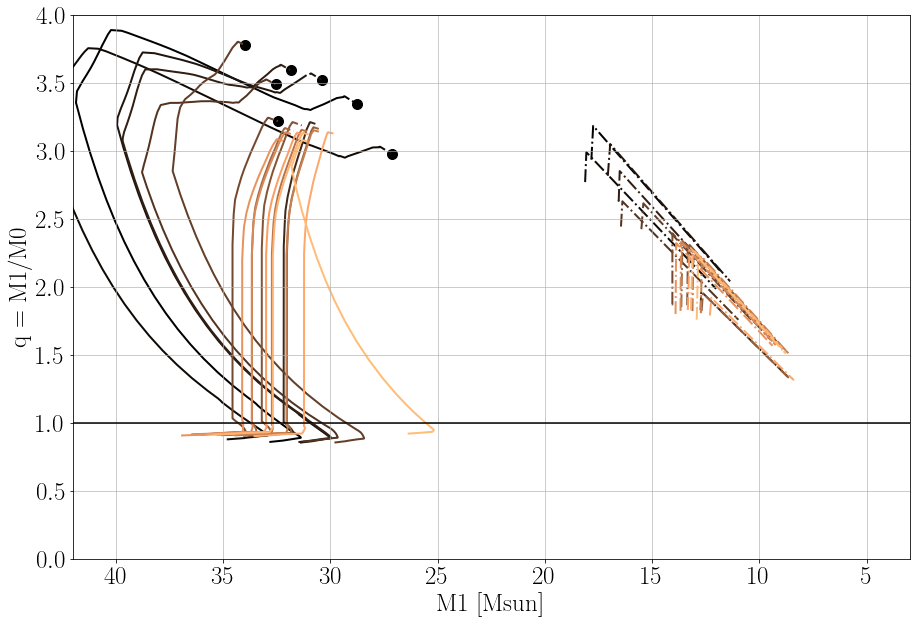

In [12]:
def plotphasesqcrit(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    prog,init,fin,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple
        

    
    for c,name in zip(colors,sortednames):  #10 
        singleout = out[out.name == name]    # all outputs of single binary
        
        
        # add column
        singleout.loc[:,'q'] = q(singleout,num)
        plotPhaseBSE(ax, xaxis,yaxis,phasebse, singleout, c,lw=2, z=1)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(1,color='k',linestyle='solid')
    ax.axvline(1,color='k',linestyle='solid')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid('dotted',alpha=0.8)
    return fig

num=1
numaccr = 1-num
xaxis, yaxis = f'Mass_{num}',f'q'
xlabel, ylabel = f'M1 [Msun]',f'q = M1/M0 '
xlim = [42,3]
ylim = [0,4]
fig = plotphasesqcrit(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname)
plt.show()
fig.savefig(f'{path_results}/{dfname}/phase_qcrit1_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/phase_qcrit1_{dfname}.pdf')

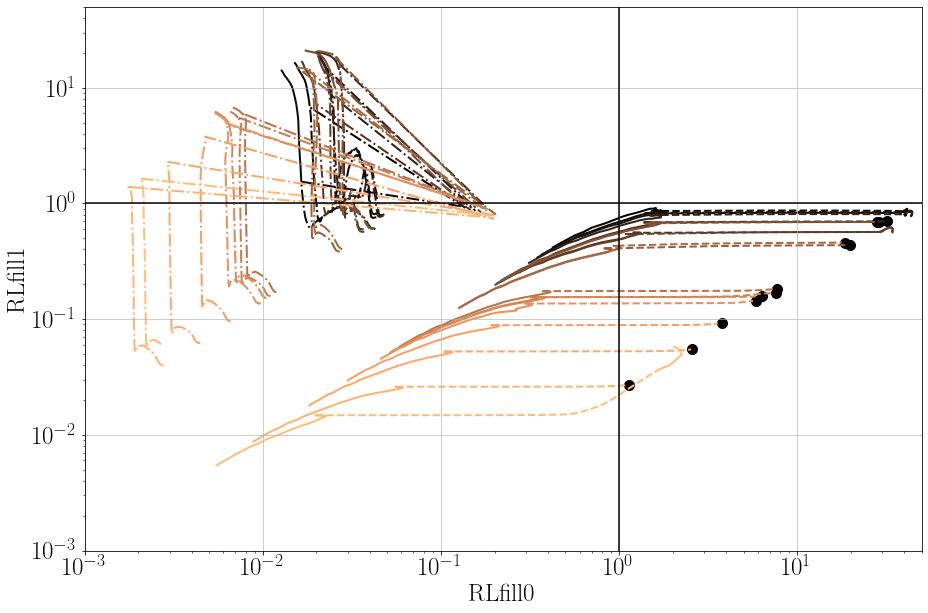

In [13]:
def plotphasesRLfill12(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    prog,init,fin,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple

    for c,name in zip(colors,sortednames):  #10 
        singleout = out[out.name == name]    # all outputs of single binary
        #singleout = singleout.loc[singleout[yaxis] <=1.]
        plotPhaseBSE(ax, xaxis,yaxis,phasebse, singleout, c,lw=2, z=1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(1,color='k',linestyle='solid')
    ax.axvline(1,color='k',linestyle='solid')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid('dotted',alpha=0.8)
    return fig

num=0
numaccr = 1-num
xaxis, yaxis = f'RLfill{num}',f'RLfill{numaccr}'
xlabel, ylabel = f'RLfill{num}',f'RLfill{numaccr}'
xlim = [1e-3,50]
ylim = [1e-3,50]
fig = plotphasesRLfill12(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname)
plt.show()
fig.savefig(f'{path_results}/{dfname}/phase_{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/phase_{xaxis}_{yaxis}_{dfname}.pdf')

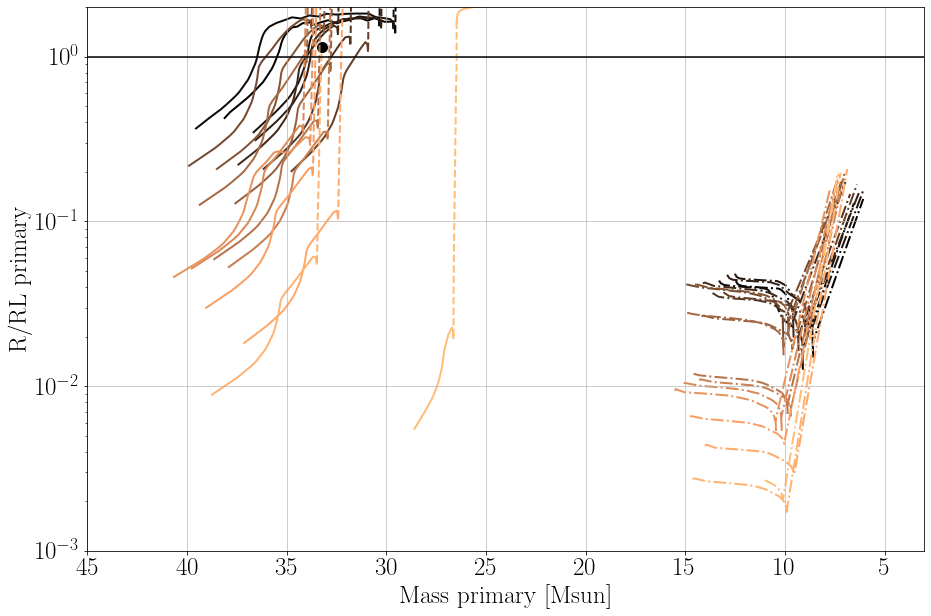

In [14]:
def plotphasesRLfill(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    prog,init,fin,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple

    for c,name in zip(colors,sortednames):  #10 
        singleout = out[out.name == name]    # all outputs of single binary
        #singleout = singleout.loc[singleout[yaxis] <=1.]
        plotPhaseBSE(ax, xaxis,yaxis,phasebse, singleout, c,lw=2, z=1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(1,color='k',linestyle='solid')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.grid('dotted',alpha=0.8)
    return fig

num = 0
xaxis, yaxis = f'Mass_{num}',f'RLfill{num}'
xlabel, ylabel = 'Mass primary [Msun]','R/RL primary'
xlim = [45,3]
ylim = [1e-3,2]
fig = plotphasesRLfill(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname)
plt.show()
fig.savefig(f'{path_results}/{dfname}/phase_{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/phase_{xaxis}_{yaxis}_{dfname}.pdf')

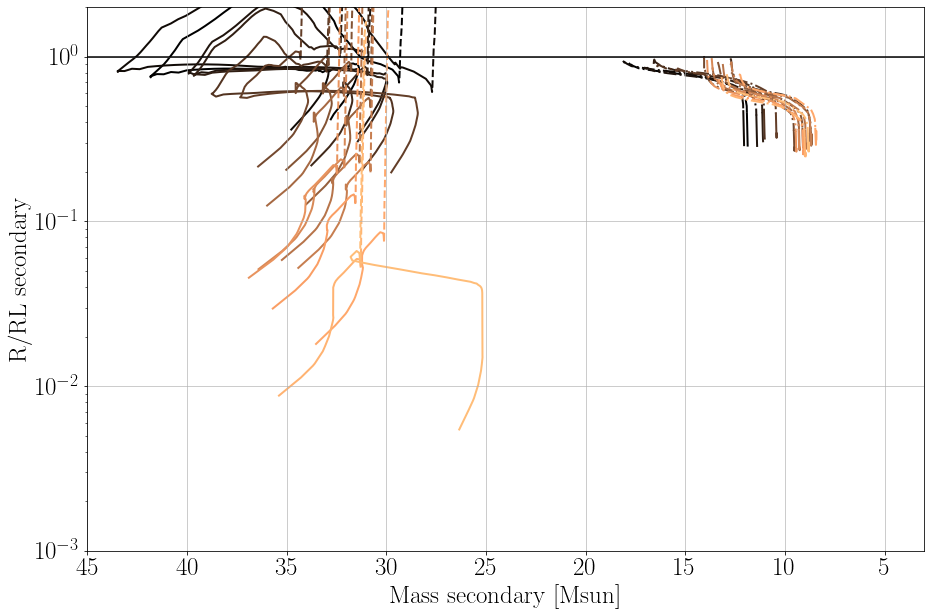

In [15]:
num = 1
xaxis, yaxis = f'Mass_{num}',f'RLfill{num}'
xlabel, ylabel = 'Mass secondary [Msun]','R/RL secondary'
xlim = [45,3]
ylim = [1e-3,2]
fig = plotphasesRLfill(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname)
plt.show()
fig.savefig(f'{path_results}/{dfname}/phase_{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/phase_{xaxis}_{yaxis}_{dfname}.pdf')

In [16]:
# select timesteps where a star "num" changes phase from phase1 to phase2
def phasechange(df,num,phase1,phase2):
    condchange2 = df[f'PhaseBSE_{num}'].shift().eq(phase1) & df[f'PhaseBSE_{num}'].eq(phase2) # select phase2
    condchange1 = df[f'PhaseBSE_{num}'].shift(-1).eq(phase2) & df[f'PhaseBSE_{num}'].eq(phase1) # select phase1
    dfchange = df[condchange1 | condchange2].reset_index()
    return dfchange

In [17]:
def plotRLO(xaxis,yaxis, num, xlabel, ylabel, xlim,yliminf,ylimsup, dfname):
    fig, axs = plt.subplots(nrows= 2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [5,1]}, figsize=(15,10))
    prog,init,fin,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple

    for c,name in zip(colors,sortednames):  #10 
        #############################################################
        ######### Extract general infos on the binary ###############
        #############################################################
        #print(name)
        singleout = out[out.name == name]    # all outputs of single binary
        singleRLOstablei = RLOstablei[RLOstablei.name == name]
        singleRLOstablef = RLOstablef[RLOstablef.name == name]
        singleRLOstableCEi = RLOstableCEi[RLOstableCEi.name == name]
        singleRLOstableCEf = RLOstableCEf[RLOstableCEf.name == name]
        
        
        # initial and final values of the mass transfer events
        timesi,timesf = singleRLOstablei.BWorldtime.values,singleRLOstablef.BWorldtime.values
        timesCEi,timesCEf = singleRLOstableCEi.BWorldtime.values,singleRLOstableCEf.BWorldtime.values
        timesalli = np.sort(np.concatenate([ np.concatenate([timesi,timesCEi]) , np.array([1e4])]))
        timesallf = np.sort(np.concatenate([ np.concatenate([timesf,timesCEf]), np.array([0.])]))
        
        
        # extract SN event
        SNcond = singleout[f'PhaseBSE_{num}'].shift().ne(14) & singleout[f'PhaseBSE_{num}'].eq(14) # select 14
        preSNcond = singleout[f'PhaseBSE_{num}'].shift(-1).eq(14) & singleout[f'PhaseBSE_{num}'].ne(14)  # before 14
        SN = singleout[SNcond] # remnant at the SN explosion
        preSN = singleout[preSNcond]
        SNevent = pd.concat([SN,preSN])
        SNsecondary = singleout[singleout[f'PhaseBSE_1'].shift().ne(14) & singleout[f'PhaseBSE_1'].eq(14)] # select 14]
        preSNprimary = singleout[singleout[f'PhaseBSE_0'].shift(-1).eq(14) & singleout[f'PhaseBSE_0'].ne(14)]
        
        # extract WR first event
        WRcond = singleout[f'PhaseBSE_{num}'].shift().lt(7) & singleout[f'PhaseBSE_{num}'].eq(7) # select 7
        WRevent= singleout[WRcond]
        WReventprimary = singleout[singleout[f'PhaseBSE_0'].shift().lt(7) & singleout[f'PhaseBSE_0'].eq(7)]
        
        # first and last event of all the evolution
        progenitor = singleout.drop_duplicates(subset=['name'], keep='first',ignore_index=True)
        remnant = singleout.drop_duplicates(subset=['name'], keep='last',ignore_index=True)

        
        
        
        for ax in axs: 
            #########################################
            ######### plot stable RLO  ##############
            #########################################
            for timei, timef in zip(timesi,timesf):
                singleRLOstable = singleout[(singleout.BWorldtime >= timei) & (singleout.BWorldtime <= timef)]
                
                # phase changes
                singleRLOstable27 =  phasechange(singleRLOstable,num,2,7)
                singleRLOstable37 =  phasechange(singleRLOstable,num,3,7)
                singleRLOstable47 =  phasechange(singleRLOstable,num,4,7)
                singleRLOstable57 =  phasechange(singleRLOstable,num,5,7)
                singleRLOstable48 =  phasechange(singleRLOstable,num,4,8)
                singleRLOstable58 =  phasechange(singleRLOstable,num,5,8)
                singleRLOstable87 =  phasechange(singleRLOstable,num,8,7)
                
                changelist = [singleRLOstable27,singleRLOstable37, singleRLOstable47, singleRLOstable57,
                             singleRLOstable48,singleRLOstable58,singleRLOstable87]
                timeschange = np.concatenate([timesi,timesf])
                
                
                for changedf in changelist:
                    timeschange = np.concatenate([timeschange,changedf.BWorldtime.values])
                    ax.plot(changedf[xaxis].values,changedf[yaxis].values,color= 'dodgerblue', lw=3, linestyle='dashed',zorder=3)
                timeschange = np.sort(timeschange)
                
                # plot as separate pieces between the phase changes
                for i in range(0,len(timeschange)-1):
                    singlephase = singleRLOstable[(singleRLOstable.BWorldtime >= timeschange[i]) & (singleRLOstable.BWorldtime <= timeschange[i+1]) ]
                    #if primary is RL filling plot dashed
                    if singleRLOstable[singleRLOstable.BWorldtime == timei].RLfill0.values[0] >=1.:              
                        ax.plot(singlephase[xaxis].values,singlephase[yaxis].values,color= 'dodgerblue', lw=3,linestyle='dashed',zorder=3)
                    else:         
                        ax.plot(singlephase[xaxis].values,singlephase[yaxis].values,color= 'dodgerblue', lw=3, linestyle='solid',zorder=3)

            
            
            ##########################################################     
            ######### plot stable RLO that ends in a CE ##############
            ##########################################################
            # select a single mass transfer episode per time
            for timeCEi, timeCEf in zip(timesCEi,timesCEf):
                singleRLOstableCE = singleout[(singleout.BWorldtime >= timeCEi) & (singleout.BWorldtime <= timeCEf) ] # before CE
                
                # pick last value of CE and plot the CE event
                endCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7)]
                startCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7).shift(-1)]
                CEevent = pd.concat([startCErow,endCErow])
                ax.plot(CEevent[xaxis].values,CEevent[yaxis].values,color= 'salmon', alpha = 0.8,linestyle='dotted',zorder=4)
                
                # single phases
                ax.scatter(CEevent[CEevent[f'PhaseBSE_0'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_0'] == 3.0][yaxis].values, c= 'fuchsia',ec='k',s=150, zorder = 1)
                #ax.scatter(singleout[singleout[f'PhaseBSE_0'] == 4.0][xaxis].values, singleout[singleout[f'PhaseBSE_0'] == 4.0][f'Mass_{num}'].values/singleout[singleout[f'PhaseBSE_0'] == 4.0][f'Mass_{numaccr}'].values, marker='s',c= 'fuchsia',ec='k',s=100, zorder = 6)

                ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 3.0][yaxis].values, c= 'cyan', ec='k',s=150, zorder = 1)
                ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 4.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 4.0][yaxis].values, c= 'cyan', ec='k', marker='d',s=150, zorder = 1)

                
                # phase changes
                singleRLOstableCE27 =  phasechange(singleRLOstableCE,num,2,7)
                singleRLOstableCE37 =  phasechange(singleRLOstableCE,num,3,7)
                singleRLOstableCE47 =  phasechange(singleRLOstableCE,num,4,7)
                singleRLOstableCE57 =  phasechange(singleRLOstableCE,num,5,7)
                singleRLOstableCE48 =  phasechange(singleRLOstableCE,num,4,8)
                singleRLOstableCE58 =  phasechange(singleRLOstableCE,num,5,8)
                singleRLOstableCE87 =  phasechange(singleRLOstableCE,num,8,7)
                
                changelistCE = [singleRLOstableCE27,singleRLOstableCE37, singleRLOstableCE47, singleRLOstableCE57,
                             singleRLOstableCE48,singleRLOstableCE58,singleRLOstableCE87]
                timeschangeCE = np.concatenate([timesCEi,timesCEf])

                for changedfCE in changelistCE:
                    timeschangeCE = np.concatenate([timeschangeCE,changedfCE.BWorldtime.values])

                timeschangeCE = np.sort(timeschangeCE)
                
                # plot as separate pieces between the phase changes
                for i in range(0,len(timeschangeCE)-1):
                    condbase = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1])
                    condphasenotWR = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1]) & (singleRLOstableCE[f'PhaseBSE_{num}'] < 7.)
                    singlephaseCE = singleRLOstableCE[ condbase | condphasenotWR]
                    #if primary is RL filling plot dashed
                    if singleRLOstableCE[singleRLOstableCE.BWorldtime == timeCEi].RLfill0.values[0] >=1.:              
                        ax.plot(singlephaseCE[xaxis].values,singlephaseCE[yaxis].values,color= 'darkred', lw = 3, linestyle='dashed',zorder=3)
                    else:         
                        ax.plot(singlephaseCE[xaxis].values,singlephaseCE[yaxis].values,color= 'darkred', lw=3, linestyle='solid',zorder=3)

            
            
            
            ######################################################          
            ####### plot all other evolutionary phases ###########
            ######################################################
            for timealli,timeallf in zip(timesalli,timesallf):
                if (timeallf in timesf) | (timealli == timesalli[0]): # only if end of RLO stable or starts in ZAMS take also that timestep
                    singlepiece= singleout[((singleout.BWorldtime > timeallf) & (singleout.BWorldtime <= timealli))]
                else:
                    singlepiece= singleout[((singleout.BWorldtime > timeallf) & (singleout.BWorldtime <= timealli))]
        
                
                singlepiecenorem = singlepiece[singlepiece[f'PhaseBSE_{num}'] != 14.0]

                ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=4)
#                 if len(timesi) >0: # if period BBH < 7 hours
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)
#                 else:
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)

                # SN plot
                ax.plot(SNevent[xaxis].values, SNevent[yaxis].values, color= 'lightgrey', alpha =0.1, linestyle='solid',zorder=1)


                if num == 0:
                    WRmarker='s'
                    WRcolor = 'lightgrey'
                    SNcolor = 'k'
                elif num == 1:
                    WRmarker='o'
                    WRcolor = 'dimgrey'
                    SNcolor = 'gold'
                
                # first WR event
                ax.scatter(WRevent[xaxis].values,WRevent[yaxis].values,c=WRcolor, ec='k',marker = WRmarker, s=100,zorder=3)
                
                if xaxis == 'BWorldtime':  # if it is the period vs time plot add the SN of the primary
                    ax.scatter(WReventprimary[xaxis].values,WReventprimary[yaxis].values,c='lightgrey', ec='k',marker = 's', s=100,zorder=2)
                    ax.scatter(preSNprimary[xaxis].values,preSNprimary[yaxis].values, c='k',ec='k',marker = '*', s=300, zorder=2)
                    # enhance the SN explosion of the secondary
                    ax.scatter(preSN[xaxis].values,preSN[yaxis].values, c=SNcolor,ec='k',marker = '*', s=200, zorder=5) 
                else:
                    ax.scatter(preSN[xaxis].values,preSN[yaxis].values, c=SNcolor,ec='k',marker = '*', s=200, zorder=3)
                    
                    # progenitor and remnant
                    ax.scatter(progenitor[xaxis].values,progenitor[yaxis].values,facecolors='none',
                           edgecolor='k',marker = 'o', s = 100,zorder=5)
                    ax.scatter(remnant[xaxis].values,remnant[yaxis].values,facecolors= 'k',
                           edgecolor='k',marker = 'o', s = 10, zorder=5)
                    
            
         
                
                
    ############################################
    ######## refine plot properties ############
    ############################################
    # cut y axis
    axs[0].set_ylim(ylimsup[0], ylimsup[1])  # outliers only
    axs[1].set_ylim(yliminf[0], yliminf[1])  # outliers only

    # hide the horizontal delimiters (spines) between the two subplots
    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[0].xaxis.tick_top()
    axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
    axs[1].xaxis.tick_bottom()

    # add diagonal lines
    d = 0.25
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
    axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
    
    if ppisn == 'only':
        axs[0].axvline(3,color='k',linestyle='dotted')
        axs[1].axvline(3,color='k',linestyle='dotted')
    if yaxis == 'RLfill0' or yaxis=='RLfill1':
        axs[0].axhline(1., linestyle='solid', color='k')
    
    
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[0].yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)
    axs[1].yaxis.set_major_locator(ticker.LogLocator(base=10))
    axs[1].yaxis.set_minor_formatter(ticker.NullFormatter())
    
    # other settings
    axs[0].set_xlim(xlim)
    
    axs[1].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    
    axs[0].grid(linestyle='dotted',alpha=0.8)
    axs[1].grid(linestyle='dotted',alpha=0.8)

    ######### legend ###########
    class AnyObjectHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                       linestyle=orig_handle[0], lw=3, color=orig_handle[1])
            l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                       linestyle=orig_handle[2], lw=3, color=orig_handle[3])
            return [l1, l2]
    
    p1, = axs[1].plot([0], [0], 'o', mfc="w", mec='k',ms=11)
    p22, = axs[1].plot([0], [0], 's', mfc="lightgrey",mec='k',ms=11)  #primary WR
    p2, = axs[1].plot([0], [0], WRmarker, mfc=WRcolor,mec='k',ms=11)
    p33, = axs[1].plot([0], [0], '*', mfc='k', mec='k',ms=18)        # primary SN
    p3, = axs[1].plot([0], [0], '*', mfc=SNcolor, mec='k',ms=18)        
    p4, = axs[1].plot([0], [0], 'o', mfc="k", mec='k',ms=5)
    l0, = axs[1].plot([0], [0], color = 'r', linestyle = 'dotted')
    
    mt1, = axs[1].plot([0], [0], 'o', mfc="fuchsia", mec='k',ms=11)
    mt2, = axs[1].plot([0], [0], 'o', mfc="cyan", mec='k',ms=11)
    mt3, = axs[1].plot([0], [0], 'd', mfc="cyan", mec='k',ms=11)
    
    
    
    if (xaxis == 'Mass_0') | (xaxis == 'Mass_1'):             
        axs[1].legend([p1, p2,p3,p4, l0, ('--','darkred','--','dodgerblue'), ('-','darkred','-','dodgerblue'),mt1,mt2,mt3], 
                      ['ZAMS','WR','SN','BH','CE','RLO primary', "RLO secondary",'GB primary','GB secondary', 'CHeB secondary'],
                   handler_map={tuple: AnyObjectHandler()}, loc = 'lower left',ncol=3)

    else:
        axs[0].legend([p22,p33,p2,p3, l0, ('--','darkred','--','dodgerblue'), ('-','darkred','-','dodgerblue'),mt1,mt2,mt3], 
                      ['WR primary','SN primary','WR secondary','SN secondary','CE','RLO primary', "RLO secondary",
                      'GB primary','GB secondary', 'CHeB secondary'],
                   handler_map={tuple: AnyObjectHandler()}, loc = 'upper right')

    plt.subplots_adjust( hspace=0.05 )    
    return fig

In [18]:
# xaxis, yaxis = 'Hsup_0', 'Radius_0'
# num = 0
# xlim = [.8,0.01]  #0.72-0.6
# ylimsup = [5,5500]
# yliminf = [1e-5,7e-5]
# xlabel, ylabel = r' Hsup primary', r' Radius primary [$R_\odot$]'
# dfname = r'BHBH_GW_WRBH_cyg_x-3--Ko17'
# fig = plotRLO(xaxis, yaxis, num, xlabel, ylabel, xlim,yliminf,ylimsup,dfname)

# plt.show()
# #fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}')

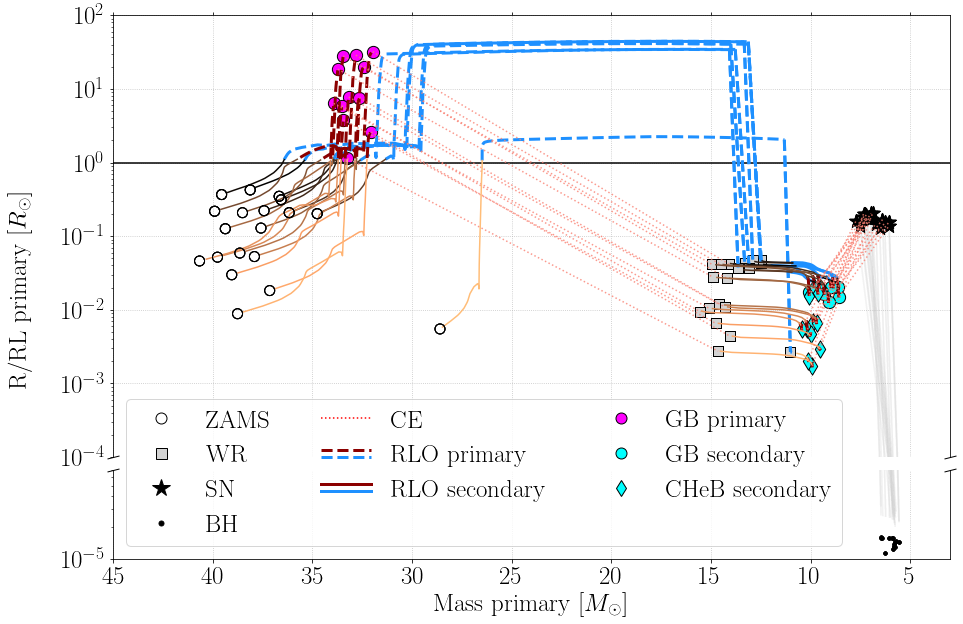

In [19]:
xaxis, yaxis = 'Mass_0', 'RLfill0'
num = 0
if ppisn == 'only':
    xlim = [30,0]
    ylimsup = [1e-2,1500]  
    yliminf = [1e-5,7e-5]
    dfname = r'BHBH_GW_WRBH'
else:
    xlim = [45,3]
    ylimsup = [1e-4,100] #1e-4,100
    yliminf = [1e-5,7e-5] # 1e-5,7e-5
    dfname = r'BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r' Mass primary [$M_\odot$]', r' R/RL primary [$R_\odot$]'
fig = plotRLO(xaxis, yaxis, num, xlabel, ylabel, xlim,yliminf,ylimsup,dfname)

plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

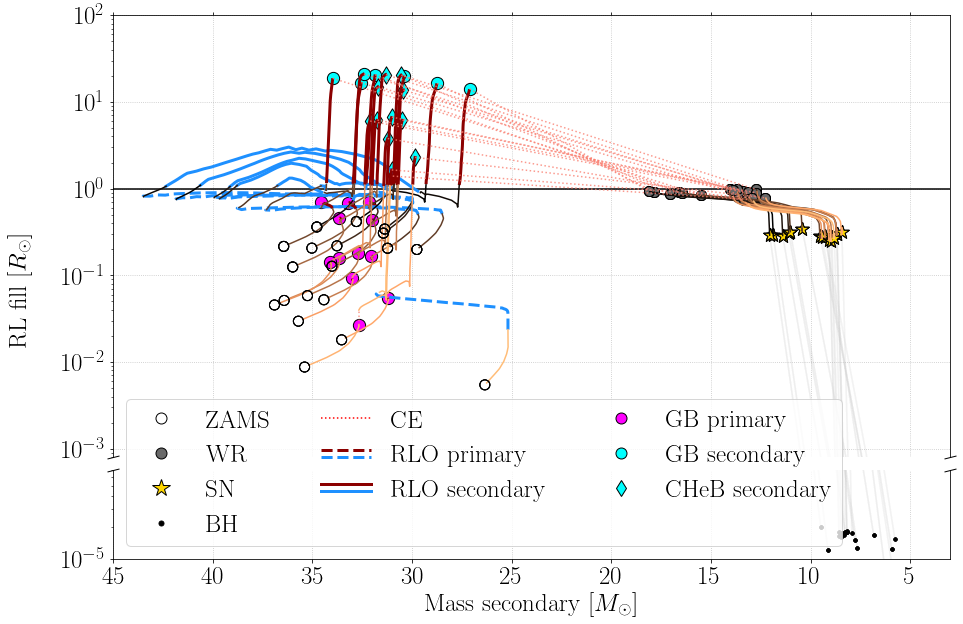

In [20]:
xaxis, yaxis = 'Mass_1', 'RLfill1'
num = 1
if ppisn == 'only':
    xlim = [30,0]  #45,3
    ylimsup = [1e-2,5000]  #8e-2
    yliminf = [1e-6,7e-5]
    dfname = r'BHBH_GW_WRBH'
else:
    xlim = [45,3]  #45,3     # 45,25
    ylimsup = [8e-4,100]  #8e-2,5000   # 8e-4,100
    yliminf = [1e-5,7e-5]
    dfname='BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r' Mass secondary [$M_\odot$]', r' RL fill [$R_\odot$]'
fig = plotRLO(xaxis, yaxis, num ,xlabel,ylabel,xlim,yliminf,ylimsup,dfname)


plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

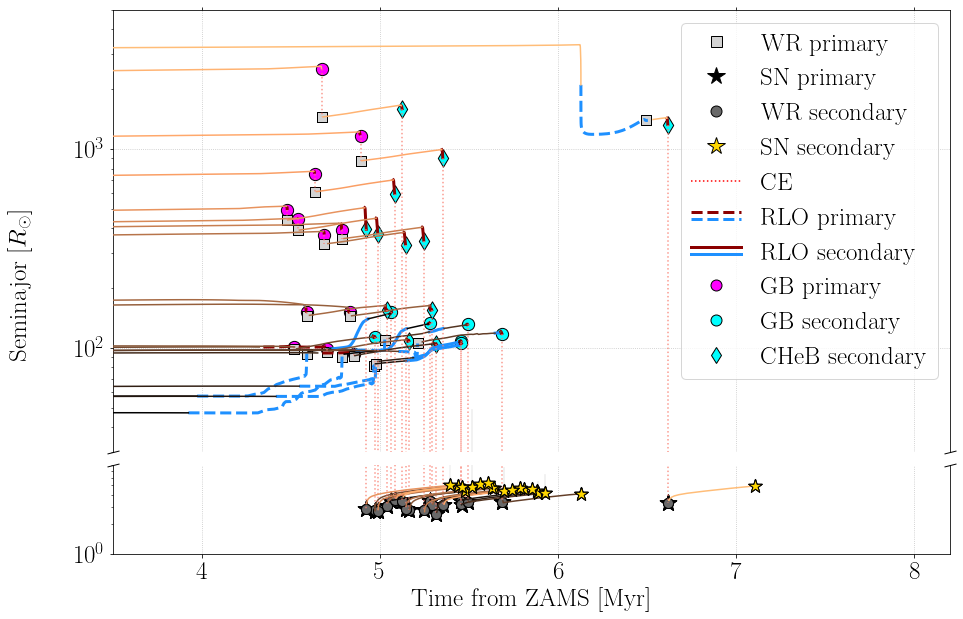

In [21]:
xaxis, yaxis = 'BWorldtime', 'Semimajor'
num = 1
if ppisn == 'only':
    xlim = [6.5, 10.5]  #3.5,8.2
    ylimsup = [30,5000]
    yliminf = [0.1,8]   #1,8
    dfname=r'BHBH_GW_WRBH'
else:
    xlim = [3.5,8.2]  #3.5,8.2
    ylimsup = [30,5000]  #30
    yliminf = [1,8]   #1,8
    dfname=r'BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r'Time from ZAMS [Myr]', r' Seminajor [$R_\odot$]'
fig = plotRLO(xaxis, yaxis, num , xlabel, ylabel, xlim,yliminf,ylimsup, dfname)
    
plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

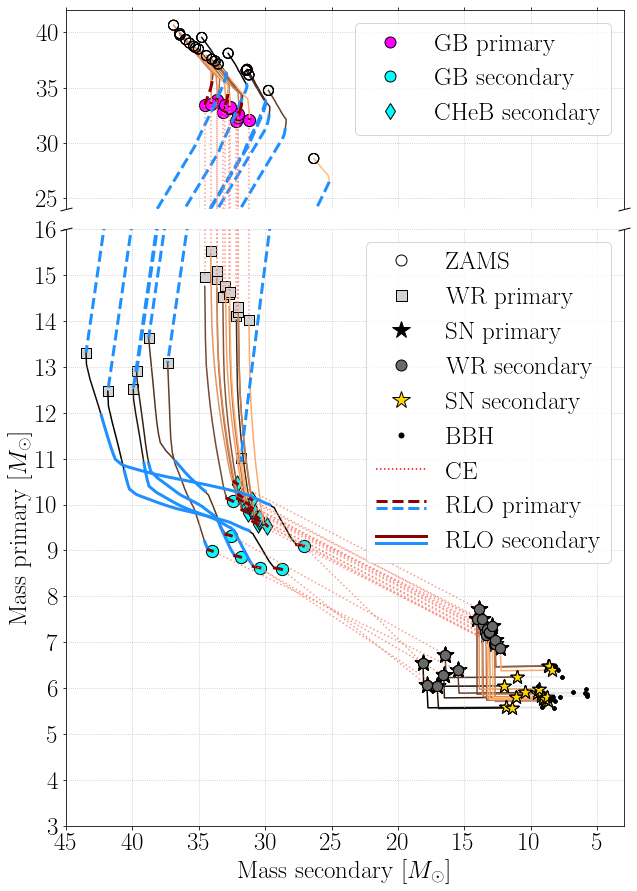

In [22]:
def plotRLOM1M2(xaxis,yaxis, num, xlabel, ylabel, xlim,yliminf,ylimsup, dfname):
    fig, axs = plt.subplots(nrows= 2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1,3]},figsize=(10,15))
    prog,init,fin,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple

    for c,name in zip(colors,sortednames):  #10 
        #############################################################
        ######### Extract general infos on the binary ###############
        #############################################################
        #print(name)
        singleout = out[out.name == name]    # all outputs of single binary
        singleRLOstablei = RLOstablei[RLOstablei.name == name]
        singleRLOstablef = RLOstablef[RLOstablef.name == name]
        singleRLOstableCEi = RLOstableCEi[RLOstableCEi.name == name]
        singleRLOstableCEf = RLOstableCEf[RLOstableCEf.name == name]
        
        
        # initial and final values of the mass transfer events
        timesi,timesf = singleRLOstablei.BWorldtime.values,singleRLOstablef.BWorldtime.values
        timesCEi,timesCEf = singleRLOstableCEi.BWorldtime.values,singleRLOstableCEf.BWorldtime.values
        timesalli = np.sort(np.concatenate([ np.concatenate([timesi,timesCEi]) , np.array([1e4])]))
        timesallf = np.sort(np.concatenate([ np.concatenate([timesf,timesCEf]), np.array([0.])]))
        
        
        # extract SN event for secondary
        SNcond = singleout[f'PhaseBSE_1'].shift().ne(14) & singleout[f'PhaseBSE_1'].eq(14) # select 14
        preSNcond = singleout[f'PhaseBSE_1'].shift(-1).eq(14) & singleout[f'PhaseBSE_1'].ne(14)  # before 14
        SN = singleout[SNcond] # remnant at the SN explosion
        preSN = singleout[preSNcond]
        SNevent = pd.concat([SN,preSN])

        preSNprimary = singleout[singleout[f'PhaseBSE_0'].shift(-1).eq(14) & singleout[f'PhaseBSE_0'].ne(14)]
        SNprimary = singleout[singleout[f'PhaseBSE_1'].shift().ne(14) & singleout[f'PhaseBSE_1'].eq(14)] # select 14
        SNeventprimary = pd.concat([SNprimary,preSNprimary])
        
        # extract WR first event
        WRcond = singleout[f'PhaseBSE_{num}'].shift().lt(7) & singleout[f'PhaseBSE_{num}'].eq(7) # select 7
        WRevent= singleout[WRcond]
        WReventprimary= singleout[singleout[f'PhaseBSE_0'].shift().lt(7) & singleout[f'PhaseBSE_0'].eq(7)]
        
        # first and last event of all the evolution
        progenitor = singleout.drop_duplicates(subset=['name'], keep='first',ignore_index=True)
        remnant = singleout.drop_duplicates(subset=['name'], keep='last',ignore_index=True)

        
        
        for ax in axs:
            #########################################
            ######### plot stable RLO  ##############
            #########################################
            for timei, timef in zip(timesi,timesf):
                singleRLOstable = singleout[(singleout.BWorldtime >= timei) & (singleout.BWorldtime <= timef)]

                # phase changes
                singleRLOstable27 =  phasechange(singleRLOstable,num,2,7)
                singleRLOstable37 =  phasechange(singleRLOstable,num,3,7)
                singleRLOstable47 =  phasechange(singleRLOstable,num,4,7)
                singleRLOstable57 =  phasechange(singleRLOstable,num,5,7)
                singleRLOstable48 =  phasechange(singleRLOstable,num,4,8)
                singleRLOstable58 =  phasechange(singleRLOstable,num,5,8)
                singleRLOstable87 =  phasechange(singleRLOstable,num,8,7)

                changelist = [singleRLOstable27,singleRLOstable37, singleRLOstable47, singleRLOstable57,
                             singleRLOstable48,singleRLOstable58,singleRLOstable87]
                timeschange = np.concatenate([timesi,timesf])

                for changedf in changelist:
                    timeschange = np.concatenate([timeschange,changedf.BWorldtime.values])
                    ax.plot(changedf[xaxis].values,changedf[yaxis].values,color= 'dodgerblue', linestyle='dashed', lw=3, zorder=2)
                timeschange = np.sort(timeschange)

                # plot as separate pieces between the phase changes
                for i in range(0,len(timeschange)-1):
                    singlephase = singleRLOstable[(singleRLOstable.BWorldtime >= timeschange[i]) & (singleRLOstable.BWorldtime <= timeschange[i+1]) ]
                    #if primary is RL filling plot dashed
                    if singleRLOstable[singleRLOstable.BWorldtime == timei].RLfill0.values[0] >=1.:              
                        ax.plot(singlephase[xaxis].values,singlephase[yaxis].values,color= 'dodgerblue', linestyle='dashed', lw=3, zorder=2)
                    else:         
                        ax.plot(singlephase[xaxis].values,singlephase[yaxis].values,color= 'dodgerblue', linestyle='solid',lw=3,zorder=2)



            ##########################################################     
            ######### plot stable RLO that ends in a CE ##############
            ##########################################################
            # select a single mass transfer episode per time
            for timeCEi, timeCEf in zip(timesCEi,timesCEf):
                singleRLOstableCE = singleout[(singleout.BWorldtime >= timeCEi) & (singleout.BWorldtime <= timeCEf) ] # before CE

                # pick last value of CE and plot the CE event
                endCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7)]
                startCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7).shift(-1)]
                CEevent = pd.concat([startCErow,endCErow])
                ax.plot(CEevent[xaxis].values,CEevent[yaxis].values,color= 'salmon', alpha = 0.8,linestyle='dotted',zorder=2)

                # single phases
                ax.scatter(CEevent[CEevent[f'PhaseBSE_0'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_0'] == 3.0][yaxis].values, c= 'fuchsia',ec='k',s=150, zorder = 1)
                ax.scatter(CEevent[CEevent[f'PhaseBSE_0'] == 4.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_0'] == 4.0][yaxis].values, marker='d',c= 'fuchsia',ec='k',s=100, zorder = 6)

                ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 3.0][yaxis].values, c= 'cyan', ec='k',s=150, zorder = 1)
                ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 4.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 4.0][yaxis].values, c= 'cyan', ec='k', marker='d',s=150, zorder = 1)

                
                # phase changes
                singleRLOstableCE27 =  phasechange(singleRLOstableCE,num,2,7)
                singleRLOstableCE37 =  phasechange(singleRLOstableCE,num,3,7)
                singleRLOstableCE47 =  phasechange(singleRLOstableCE,num,4,7)
                singleRLOstableCE57 =  phasechange(singleRLOstableCE,num,5,7)
                singleRLOstableCE48 =  phasechange(singleRLOstableCE,num,4,8)
                singleRLOstableCE58 =  phasechange(singleRLOstableCE,num,5,8)
                singleRLOstableCE87 =  phasechange(singleRLOstableCE,num,8,7)

                changelistCE = [singleRLOstableCE27,singleRLOstableCE37, singleRLOstableCE47, singleRLOstableCE57,
                             singleRLOstableCE48,singleRLOstableCE58,singleRLOstableCE87]
                timeschangeCE = np.concatenate([timesCEi,timesCEf])

                for changedfCE in changelistCE:
                    timeschangeCE = np.concatenate([timeschangeCE,changedfCE.BWorldtime.values])
                    
                timeschangeCE = np.sort(timeschangeCE)

                # plot as separate pieces between the phase changes
                for i in range(0,len(timeschangeCE)-1):
                    condbase = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1])
                    condphasenotWR = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1]) & (singleRLOstableCE[f'PhaseBSE_{num}'] < 7.)
                    singlephaseCE = singleRLOstableCE[ condbase | condphasenotWR]
                    #if primary is RL filling plot dashed
                    if ppisn == 'only':
                        order,orderSN = 1,2
                    else:
                        order,orderSN = 2,1
                    if singleRLOstableCE[singleRLOstableCE.BWorldtime == timeCEi].RLfill0.values[0] >=1.:
                        ax.plot(singlephaseCE[xaxis].values,singlephaseCE[yaxis].values,color= 'darkred', linestyle='dashed', lw=3,zorder=order)
                    else:         
                        ax.plot(singlephaseCE[xaxis].values,singlephaseCE[yaxis].values,color= 'darkred', linestyle='solid', lw=3, zorder=order)




            ######################################################          
            ####### plot all other evolutionary phases ###########
            ######################################################
            for timealli,timeallf in zip(timesalli,timesallf):
                if (timeallf in timesf) | (timealli == timesalli[0]): # only if end of RLO stable or start in ZAMS
                    singlepiece= singleout[((singleout.BWorldtime >= timeallf) & (singleout.BWorldtime <= timealli))]
                elif timeallf == WRevent.BWorldtime.values[0]: # when the CE produces WR for secondary
                    singlepiece= singleout[((singleout.BWorldtime > timeallf) & (singleout.BWorldtime <= timealli))]
                    singlepiece = pd.concat([singlepiece, WRevent]).sort_values(by=['BWorldtime']) 
                else:
                    singlepiece= singleout[((singleout.BWorldtime > timeallf) & (singleout.BWorldtime <= timealli))]

                
                singlepiecenorem = singlepiece[singlepiece[f'PhaseBSE_{num}'] != 14.0]   
                ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)
#                 else:
#                 if len(timesi) >0: # if goes through at least one stable RLO
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= 'k', linestyle='solid',zorder=1)
#                 else:
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= 'darkgrey', linestyle='solid',zorder=1)

                # SN plot
                ax.plot(SNevent[xaxis].values, SNevent[yaxis].values, color= 'lightgrey', alpha =0.1, linestyle='solid',zorder=1)

                # progenitor and remnant
                ax.scatter(progenitor[xaxis].values,progenitor[yaxis].values,facecolors='none',
                           edgecolor='k',marker = 'o', s = 100,zorder=4)
                ax.scatter(remnant[xaxis].values,remnant[yaxis].values,facecolors= 'k',
                           edgecolor='k',marker = 'o', s = 10, zorder=4)

                # first WR event
                ax.scatter(WRevent[xaxis].values,WRevent[yaxis].values,c='dimgrey', ec='k',marker = 'o', s=100,zorder=3)
                ax.scatter(WReventprimary[xaxis].values,WReventprimary[yaxis].values,c='lightgrey', ec='k',marker = 's', s=100,zorder=1)
                
                # SN explosion
                ax.scatter(preSN[xaxis].values,preSN[yaxis].values, c='gold',ec='k',marker = '*', s=200, zorder=3)
                ax.scatter(preSNprimary[xaxis].values,preSNprimary[yaxis].values, c='k',ec='k',marker = '*', s=300, zorder=1)
    





    ############################################
    ######## refine plot properties ############
    ###########################################
    # cut y axis
    axs[0].set_ylim(ylimsup[0], ylimsup[1])  # outliers only
    axs[1].set_ylim(yliminf[0], yliminf[1])  # outliers only

    # hide the horizontal delimiters (spines) between the two subplots
    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[0].xaxis.tick_top()
    axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
    axs[1].xaxis.tick_bottom()

    # add diagonal lines
    d = 0.25
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
    axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
    
    # other settings
    axs[0].set_xlim(xlim)
    
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)
    
    axs[0].xaxis.set_major_locator(ticker.MultipleLocator(5)) # set ticks every 5 Msun
    axs[0].yaxis.set_major_locator(ticker.MultipleLocator(5)) # set ticks every 5 Msun
    axs[1].yaxis.set_major_locator(ticker.MultipleLocator(1)) # set ticks every 5 Msun


    
    axs[0].grid(linestyle='dotted',alpha=0.8)
    axs[1].grid(linestyle='dotted',alpha=0.8)
    

    ######### legend ###########
    class AnyObjectHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                       linestyle=orig_handle[0], lw=3,color=orig_handle[1])
            l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                       linestyle=orig_handle[2], lw=3,color=orig_handle[3])
            return [l1, l2]
    
    p1, = axs[0].plot([0], [0], 'o', mfc="w", mec='k',ms=11)
    p22, = axs[0].plot([0], [0], 's', mfc="lightgrey",mec='k',ms=11)
    p2, = axs[0].plot([0], [0], 'o', mfc="dimgrey",mec='k',ms=11)
    p33, = axs[0].plot([0], [0], '*', mfc="k", mec='k',ms=18)   
    p3, = axs[0].plot([0], [0], '*', mfc="gold", mec='k',ms=18)        
    p4, = axs[0].plot([0], [0], 'o', mfc="k", mec='k',ms=5)
    l0, = axs[0].plot([0], [0], color = 'r', linestyle = 'dotted')
    
    mt1, = axs[0].plot([0], [0], 'o', mfc="fuchsia", mec='k',ms=11)
    mt2, = axs[0].plot([0], [0], 'o', mfc="cyan", mec='k',ms=11)
    mt3, = axs[0].plot([0], [0], 'd', mfc="cyan", mec='k',ms=11)
    
    
    if ppisn != 'only':       
        axs[1].legend([p1, p22,p33,p2,p3,p4, l0, ('--','darkred','--','dodgerblue'), ('-','darkred','-','dodgerblue')], 
                      ['ZAMS','WR primary','SN primary','WR secondary','SN secondary','BBH','CE','RLO primary', "RLO secondary"],
                   handler_map={tuple: AnyObjectHandler()}, loc = 'upper right')
    
    axs[0].legend([mt1,mt2,mt3], ['GB primary','GB secondary', 'CHeB secondary'], 
                  handler_map={tuple: AnyObjectHandler()}, loc = 'upper right')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)    
    return fig

xaxis, yaxis = 'Mass_1', 'Mass_0'
num = 1
if ppisn == 'only':
    xlim = [30,1]         # 45,3
    ylimsup = [18,30]   #24,42
    yliminf = [2,8]    #3,16
    dfname=r'BHBH_GW_WRBH'
else:
    xlim = [45,3]         # 45,3
    ylimsup = [24,42] #24,42    #20,50 for optimistic
    yliminf = [3,16]    #3,16
    dfname=r'BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r' Mass secondary [$M_\odot$]', r' Mass primary [$M_\odot$]'
fig = plotRLOM1M2(xaxis, yaxis, num ,xlabel,ylabel,xlim,yliminf,ylimsup,dfname)


if ppisn == 'only':
    plt.axvline(3, color='k',linestyle='dotted')
    plt.axhline(3, color='k',linestyle='dotted')
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

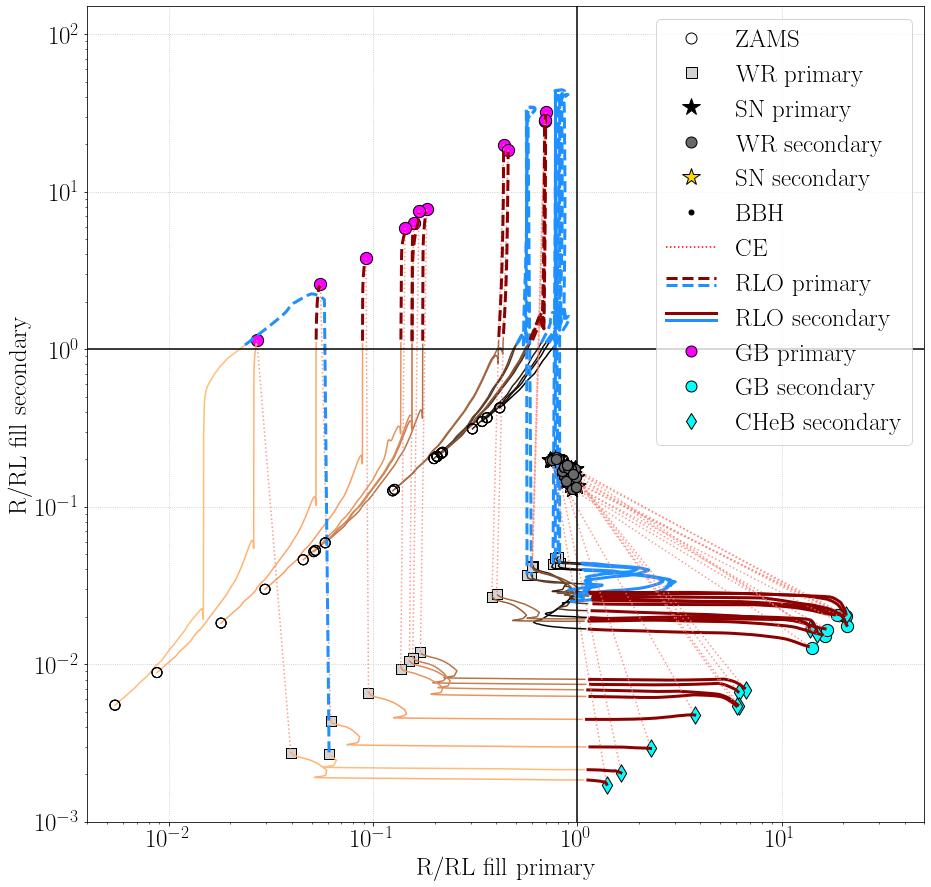

In [23]:
def plotRLOfill12(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname):
    fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(15,15))
    prog,init,fin,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    sortednames = prog.sort_values(by='a')['name'].values
    numaccr=1-num
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple

    for c,name in zip(colors,sortednames):  #10 
        #############################################################
        ######### Extract general infos on the binary ###############
        #############################################################
        #print(name)
        singleout = out[out.name == name]    # all outputs of single binary
        singleRLOstablei = RLOstablei[RLOstablei.name == name]
        singleRLOstablef = RLOstablef[RLOstablef.name == name]
        singleRLOstableCEi = RLOstableCEi[RLOstableCEi.name == name]
        singleRLOstableCEf = RLOstableCEf[RLOstableCEf.name == name]
        
        
        # initial and final values of the mass transfer events
        timesi,timesf = singleRLOstablei.BWorldtime.values,singleRLOstablef.BWorldtime.values
        timesCEi,timesCEf = singleRLOstableCEi.BWorldtime.values,singleRLOstableCEf.BWorldtime.values
        timesalli = np.sort(np.concatenate([ np.concatenate([timesi,timesCEi]) , np.array([1e4])]))
        timesallf = np.sort(np.concatenate([ np.concatenate([timesf,timesCEf]), np.array([0.])]))
        
        
        # extract SN event for secondary
        SNcond = singleout[f'PhaseBSE_1'].shift().ne(14) & singleout[f'PhaseBSE_1'].eq(14) # select 14
        preSNcond = singleout[f'PhaseBSE_1'].shift(-1).eq(14) & singleout[f'PhaseBSE_1'].ne(14)  # before 14
        SN = singleout[SNcond] # remnant at the SN explosion
        preSN = singleout[preSNcond]
        SNevent = pd.concat([SN,preSN])

        preSNprimary = singleout[singleout[f'PhaseBSE_0'].shift(-1).eq(14) & singleout[f'PhaseBSE_0'].ne(14)]
        SNprimary = singleout[singleout[f'PhaseBSE_1'].shift().ne(14) & singleout[f'PhaseBSE_1'].eq(14)] # select 14
        SNeventprimary = pd.concat([SNprimary,preSNprimary])
        
        # extract WR first event
        WRcond = singleout[f'PhaseBSE_{num}'].shift().lt(7) & singleout[f'PhaseBSE_{num}'].eq(7) # select 7
        WRevent= singleout[WRcond]
        WReventprimary= singleout[singleout[f'PhaseBSE_0'].shift().lt(7) & singleout[f'PhaseBSE_0'].eq(7)]
        
        # first and last event of all the evolution
        progenitor = singleout.drop_duplicates(subset=['name'], keep='first',ignore_index=True)
        remnant = singleout.drop_duplicates(subset=['name'], keep='last',ignore_index=True)
        
        
        # select only before the first SN
        singleout = singleout.loc[singleout.BWorldtime <= preSNprimary.BWorldtime.values[0]]

        

        #########################################
        ######### plot stable RLO  ##############
        #########################################
        for timei, timef in zip(timesi,timesf):
            singleRLOstable = singleout[(singleout.BWorldtime >= timei) & (singleout.BWorldtime <= timef)]

            # phase changes
            singleRLOstable27 =  phasechange(singleRLOstable,num,2,7)
            singleRLOstable37 =  phasechange(singleRLOstable,num,3,7)
            singleRLOstable47 =  phasechange(singleRLOstable,num,4,7)
            singleRLOstable57 =  phasechange(singleRLOstable,num,5,7)
            singleRLOstable48 =  phasechange(singleRLOstable,num,4,8)
            singleRLOstable58 =  phasechange(singleRLOstable,num,5,8)
            singleRLOstable87 =  phasechange(singleRLOstable,num,8,7)

            changelist = [singleRLOstable27,singleRLOstable37, singleRLOstable47, singleRLOstable57,
                         singleRLOstable48,singleRLOstable58,singleRLOstable87]
            timeschange = np.concatenate([timesi,timesf])

            for changedf in changelist:
                timeschange = np.concatenate([timeschange,changedf.BWorldtime.values])
                ax.plot(changedf[xaxis].values,changedf[yaxis].values,color= 'dodgerblue', linestyle='dashed', lw=3, zorder=2)
            timeschange = np.sort(timeschange)

            # plot as separate pieces between the phase changes
            for i in range(0,len(timeschange)-1):
                singlephase = singleRLOstable[(singleRLOstable.BWorldtime >= timeschange[i]) & (singleRLOstable.BWorldtime <= timeschange[i+1]) ]
                #if primary is RL filling plot dashed
                if singleRLOstable[singleRLOstable.BWorldtime == timei].RLfill0.values[0] >=1.:              
                    ax.plot(singlephase[xaxis].values,singlephase[yaxis].values,color= 'dodgerblue', linestyle='dashed', lw=3, zorder=2)
                else:         
                    ax.plot(singlephase[xaxis].values,singlephase[yaxis].values,color= 'dodgerblue', linestyle='solid',lw=3,zorder=2)



        ##########################################################     
        ######### plot stable RLO that ends in a CE ##############
        ##########################################################
        # select a single mass transfer episode per time
        for timeCEi, timeCEf in zip(timesCEi,timesCEf):
            singleRLOstableCE = singleout[(singleout.BWorldtime >= timeCEi) & (singleout.BWorldtime <= timeCEf) ] # before CE

            # pick last value of CE and plot the CE event
            endCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7)]
            startCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7).shift(-1)]
            CEevent = pd.concat([startCErow,endCErow])
            ax.plot(CEevent[xaxis].values,CEevent[yaxis].values,color= 'salmon', alpha = 0.8,linestyle='dotted',zorder=2)

            # single phases
            ax.scatter(CEevent[CEevent[f'PhaseBSE_0'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_0'] == 3.0][yaxis].values, c= 'fuchsia',ec='k',s=150, zorder = 1)
            ax.scatter(CEevent[CEevent[f'PhaseBSE_0'] == 4.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_0'] == 4.0][yaxis].values, marker='d',c= 'fuchsia',ec='k',s=100, zorder = 6)

            ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 3.0][yaxis].values, c= 'cyan', ec='k',s=150, zorder = 1)
            ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 4.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 4.0][yaxis].values, c= 'cyan', ec='k', marker='d',s=150, zorder = 1)


            # phase changes
            singleRLOstableCE27 =  phasechange(singleRLOstableCE,num,2,7)
            singleRLOstableCE37 =  phasechange(singleRLOstableCE,num,3,7)
            singleRLOstableCE47 =  phasechange(singleRLOstableCE,num,4,7)
            singleRLOstableCE57 =  phasechange(singleRLOstableCE,num,5,7)
            singleRLOstableCE48 =  phasechange(singleRLOstableCE,num,4,8)
            singleRLOstableCE58 =  phasechange(singleRLOstableCE,num,5,8)
            singleRLOstableCE87 =  phasechange(singleRLOstableCE,num,8,7)

            changelistCE = [singleRLOstableCE27,singleRLOstableCE37, singleRLOstableCE47, singleRLOstableCE57,
                         singleRLOstableCE48,singleRLOstableCE58,singleRLOstableCE87]
            timeschangeCE = np.concatenate([timesCEi,timesCEf])

            for changedfCE in changelistCE:
                timeschangeCE = np.concatenate([timeschangeCE,changedfCE.BWorldtime.values])
                
            timeschangeCE = np.sort(timeschangeCE)

            # plot as separate pieces between the phase changes
            for i in range(0,len(timeschangeCE)-1):
                condbase = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1])
                condphasenotWR = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1]) & (singleRLOstableCE[f'PhaseBSE_{num}'] < 7.)
                singlephaseCE = singleRLOstableCE[ condbase | condphasenotWR]
                #if primary is RL filling plot dashed
                if ppisn == 'only':
                    order,orderSN = 1,2
                else:
                    order,orderSN = 2,1
                if singleRLOstableCE[singleRLOstableCE.BWorldtime == timeCEi].RLfill0.values[0] >=1.:
                    ax.plot(singlephaseCE[xaxis].values,singlephaseCE[yaxis].values,color= 'darkred', linestyle='dashed', lw=3,zorder=order)
                else:         
                    ax.plot(singlephaseCE[xaxis].values,singlephaseCE[yaxis].values,color= 'darkred', linestyle='solid', lw=3, zorder=order)




        ######################################################          
        ####### plot all other evolutionary phases ###########
        ######################################################
        for timealli,timeallf in zip(timesalli,timesallf):
            if (timeallf in timesf) | (timealli == timesalli[0]): # only if end of RLO stable or start in ZAMS
                singlepiece= singleout[((singleout.BWorldtime >= timeallf) & (singleout.BWorldtime <= timealli))]
            elif timeallf == WRevent.BWorldtime.values[0]: # when the CE produces WR for secondary
                singlepiece= singleout[((singleout.BWorldtime > timeallf) & (singleout.BWorldtime <= timealli))]
                singlepiece = pd.concat([singlepiece, WRevent]).sort_values(by=['BWorldtime']) 
            else:
                singlepiece= singleout[((singleout.BWorldtime > timeallf) & (singleout.BWorldtime <= timealli))]


            singlepiecenorem = singlepiece[singlepiece[f'PhaseBSE_{num}'] != 14.0]   
            ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)
#                 else:
#                 if len(timesi) >0: # if goes through at least one stable RLO
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= 'k', linestyle='solid',zorder=1)
#                 else:
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= 'darkgrey', linestyle='solid',zorder=1)

            # SN plot
            #ax.plot(SNevent[xaxis].values, SNevent[yaxis].values, color= 'lightgrey', alpha =0.1, linestyle='solid',zorder=1)

            # progenitor and remnant
            ax.scatter(progenitor[xaxis].values,progenitor[yaxis].values,facecolors='none',
                       edgecolor='k',marker = 'o', s = 100,zorder=4)
            ax.scatter(remnant[xaxis].values,remnant[yaxis].values,facecolors= 'k',
                       edgecolor='k',marker = 'o', s = 10, zorder=4)
            

            # first WR event
            ax.scatter(WRevent[xaxis].values,WRevent[yaxis].values,c='dimgrey', ec='k',marker = 'o', s=100,zorder=3)
            ax.scatter(WReventprimary[xaxis].values,WReventprimary[yaxis].values,c='lightgrey', ec='k',marker = 's', s=100,zorder=1)

            # SN explosion
            ax.scatter(preSN[xaxis].values,preSN[yaxis].values, c='gold',ec='k',marker = '*', s=200, zorder=3)
            ax.scatter(preSNprimary[xaxis].values,preSNprimary[yaxis].values, c='k',ec='k',marker = '*', s=300, zorder=1)


    ############################################
    ######## refine plot properties ############
    ###########################################
  
    # other settings
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.axhline(1,color='k',linestyle='solid')
    ax.axvline(1,color='k',linestyle='solid')
#     ax.axhline(3,color='dodgerblue',linestyle='solid')
#     ax.axvline(3,color='dodgerblue',linestyle='solid')
#     ax.axhline(4,color='cyan',linestyle='solid')
#     ax.axvline(4,color='cyan',linestyle='solid')


    
    ax.grid(linestyle='dotted',alpha=0.8)
    ax.grid(linestyle='dotted',alpha=0.8)
    

    ######### legend ###########
    class AnyObjectHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                       linestyle=orig_handle[0], lw=3,color=orig_handle[1])
            l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                       linestyle=orig_handle[2], lw=3,color=orig_handle[3])
            return [l1, l2]
    
    p1, = ax.plot([0], [0], 'o', mfc="w", mec='k',ms=11)
    p22, = ax.plot([0], [0], 's', mfc="lightgrey",mec='k',ms=11)
    p2, = ax.plot([0], [0], 'o', mfc="dimgrey",mec='k',ms=11)
    p33, = ax.plot([0], [0], '*', mfc="k", mec='k',ms=18)   
    p3, = ax.plot([0], [0], '*', mfc="gold", mec='k',ms=18)        
    p4, = ax.plot([0], [0], 'o', mfc="k", mec='k',ms=5)
    l0, = ax.plot([0], [0], color = 'r', linestyle = 'dotted')
    
    mt1, = ax.plot([0], [0], 'o', mfc="fuchsia", mec='k',ms=11)
    mt2, = ax.plot([0], [0], 'o', mfc="cyan", mec='k',ms=11)
    mt3, = ax.plot([0], [0], 'd', mfc="cyan", mec='k',ms=11)
    
    
    
    if ppisn != 'only':       
        ax.legend([p1, p22,p33,p2,p3,p4, l0, ('--','darkred','--','dodgerblue'), ('-','darkred','-','dodgerblue'),mt1,mt2,mt3], 
                      ['ZAMS','WR primary','SN primary','WR secondary','SN secondary','BBH','CE','RLO primary', "RLO secondary",
                      'GB primary','GB secondary', 'CHeB secondary'],
                   handler_map={tuple: AnyObjectHandler()}, loc = 'upper right')

 
    return fig

xaxis, yaxis = 'RLfill1', 'RLfill0'
num = 1
if ppisn == 'only':
    xlim = [1e-3,40]         # 45,3
    ylim = [1e-3,40]    #3,16
    dfname=r'BHBH_GW_WRBH'
else:
    xlim = [4e-3,50]         # 4e-3,50
    ylim = [1e-3,150]    #1e-3,150
    dfname=r'BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r' R/RL fill primary', r' R/RL fill secondary'
fig = plotRLOfill12(xaxis, yaxis, num ,xlabel,ylabel,xlim,ylim,dfname)


if ppisn == 'only':
    plt.axvline(3, color='k',linestyle='dotted')
    plt.axhline(3, color='k',linestyle='dotted')
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

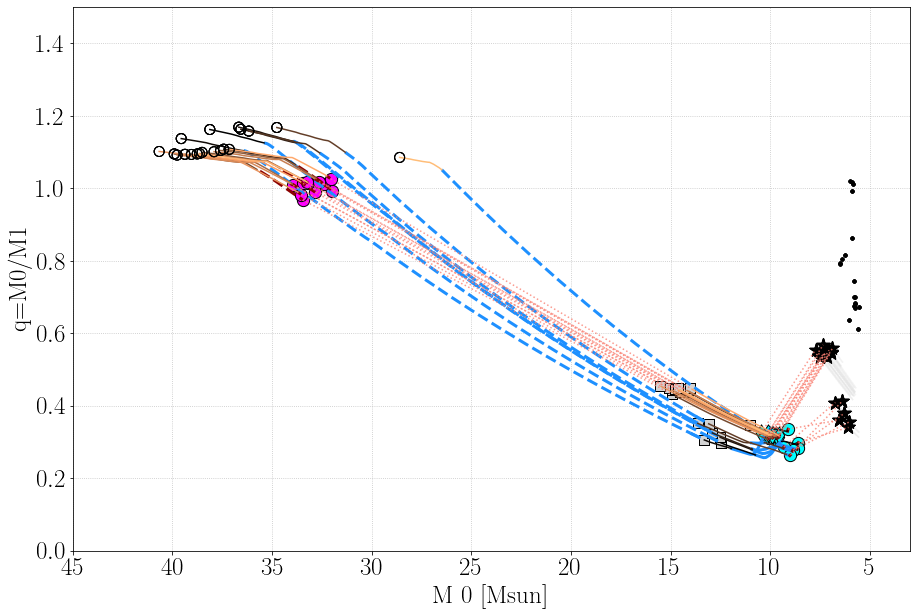

In [24]:
def plotqcrit(xaxis, num, xlabel, ylabel, xlim,ylim, dfname):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,10))
    prog,init,fin,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple
        
    numaccr=1-num  # identify if the accretor is 0 or 1

    for c,name in zip(colors,sortednames):  #10 
        #############################################################
        ######### Extract general infos on the binary ###############
        #############################################################
        #print(name)
        singleout = out[out.name == name]    # all outputs of single binary
        singleRLOstablei = RLOstablei[RLOstablei.name == name]
        singleRLOstablef = RLOstablef[RLOstablef.name == name]
        singleRLOstableCEi = RLOstableCEi[RLOstableCEi.name == name]
        singleRLOstableCEf = RLOstableCEf[RLOstableCEf.name == name]
        
        
        # initial and final values of the mass transfer events
        timesi,timesf = singleRLOstablei.BWorldtime.values,singleRLOstablef.BWorldtime.values
        timesCEi,timesCEf = singleRLOstableCEi.BWorldtime.values,singleRLOstableCEf.BWorldtime.values
        timesalli = np.sort(np.concatenate([ np.concatenate([timesi,timesCEi]) , np.array([1e4])]))
        timesallf = np.sort(np.concatenate([ np.concatenate([timesf,timesCEf]), np.array([0.])]))
        
        
        # extract SN event
        SNcond = singleout[f'PhaseBSE_{num}'].shift().ne(14) & singleout[f'PhaseBSE_{num}'].eq(14) # select 14
        preSNcond = singleout[f'PhaseBSE_{num}'].shift(-1).eq(14) & singleout[f'PhaseBSE_{num}'].ne(14)  # before 14
        SN = singleout[SNcond] # remnant at the SN explosion
        preSN = singleout[preSNcond]
        SNevent = pd.concat([SN,preSN])
        SNsecondary = singleout[singleout[f'PhaseBSE_1'].shift().ne(14) & singleout[f'PhaseBSE_1'].eq(14)] # select 14]
        preSNprimary = singleout[singleout[f'PhaseBSE_0'].shift(-1).eq(14) & singleout[f'PhaseBSE_0'].ne(14)]
        
        # extract WR first event
        WRcond = singleout[f'PhaseBSE_{num}'].shift().lt(7) & singleout[f'PhaseBSE_{num}'].eq(7) # select 7
        WRevent= singleout[WRcond]
        WReventprimary = singleout[singleout[f'PhaseBSE_0'].shift().lt(7) & singleout[f'PhaseBSE_0'].eq(7)]
        
        # first and last event of all the evolution
        progenitor = singleout.drop_duplicates(subset=['name'], keep='first',ignore_index=True)
        remnant = singleout.drop_duplicates(subset=['name'], keep='last',ignore_index=True)

        
        
        
        #########################################
        ######### plot stable RLO  ##############
        #########################################
        for timei, timef in zip(timesi,timesf):
            singleRLOstable = singleout[(singleout.BWorldtime >= timei) & (singleout.BWorldtime <= timef)]

            # phase changes
            singleRLOstable27 =  phasechange(singleRLOstable,num,2,7)
            singleRLOstable37 =  phasechange(singleRLOstable,num,3,7)
            singleRLOstable47 =  phasechange(singleRLOstable,num,4,7)
            singleRLOstable57 =  phasechange(singleRLOstable,num,5,7)
            singleRLOstable48 =  phasechange(singleRLOstable,num,4,8)
            singleRLOstable58 =  phasechange(singleRLOstable,num,5,8)
            singleRLOstable87 =  phasechange(singleRLOstable,num,8,7)

            changelist = [singleRLOstable27,singleRLOstable37, singleRLOstable47, singleRLOstable57,
                         singleRLOstable48,singleRLOstable58,singleRLOstable87]
            timeschange = np.concatenate([timesi,timesf])

            for changedf in changelist:
                timeschange = np.concatenate([timeschange,changedf.BWorldtime.values])
                ax.plot(changedf[xaxis].values,changedf[f'Mass_{num}'].values/changedf[f'Mass_{numaccr}'].values,color= 'dodgerblue', lw=3, linestyle='dashed',zorder=3)
            timeschange = np.sort(timeschange)

            # plot as separate pieces between the phase changes
            for i in range(0,len(timeschange)-1):
                singlephase = singleRLOstable[(singleRLOstable.BWorldtime >= timeschange[i]) & (singleRLOstable.BWorldtime <= timeschange[i+1]) ]
                #if primary is RL filling plot dashed
                if singleRLOstable[singleRLOstable.BWorldtime == timei].RLfill0.values[0] >=1.:              
                    ax.plot(singlephase[xaxis].values,singlephase[f'Mass_{num}'].values/singlephase[f'Mass_{numaccr}'].values,color= 'dodgerblue', lw=3,linestyle='dashed',zorder=3)
                else:         
                    ax.plot(singlephase[xaxis].values,singlephase[f'Mass_{num}'].values/singlephase[f'Mass_{numaccr}'].values,color= 'dodgerblue', lw=3, linestyle='solid',zorder=3)

            
            
        ##########################################################     
        ######### plot stable RLO that ends in a CE ##############
        ##########################################################
        # select a single mass transfer episode per time
        for timeCEi, timeCEf in zip(timesCEi,timesCEf):
            singleRLOstableCE = singleout[(singleout.BWorldtime >= timeCEi) & (singleout.BWorldtime <= timeCEf) ] # before CE

            # pick last value of CE and plot the CE event
            endCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7)]
            startCErow = singleout[(singleout.BWorldtime == timeCEf) & (singleout.BEvent == 7).shift(-1)]
            CEevent = pd.concat([startCErow,endCErow])
            ax.plot(CEevent[xaxis].values,CEevent[f'Mass_{num}'].values/CEevent[f'Mass_{numaccr}'].values,color= 'salmon', alpha = 0.8,linestyle='dotted',zorder=4)
            # single phases
            ax.scatter(CEevent[CEevent[f'PhaseBSE_0'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_0'] == 3.0][f'Mass_{num}'].values/CEevent[CEevent[f'PhaseBSE_0'] == 3.0][f'Mass_{numaccr}'].values, c= 'fuchsia',ec='k',s=150, zorder = 1)
            ax.scatter(CEevent[CEevent[f'PhaseBSE_0'] == 4.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_0'] == 4.0][f'Mass_{num}'].values/CEevent[CEevent[f'PhaseBSE_0'] == 4.0][f'Mass_{numaccr}'].values, marker='d',c= 'fuchsia',ec='k',s=100, zorder = 6)

            ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 3.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 3.0][f'Mass_{num}'].values/CEevent[CEevent[f'PhaseBSE_1'] == 3.0][f'Mass_{numaccr}'].values, c= 'cyan', ec='k',s=150, zorder = 1)
            ax.scatter(CEevent[CEevent[f'PhaseBSE_1'] == 4.0][xaxis].values, CEevent[CEevent[f'PhaseBSE_1'] == 4.0][f'Mass_{num}'].values/CEevent[CEevent[f'PhaseBSE_1'] == 4.0][f'Mass_{numaccr}'].values, c= 'cyan', ec='k', marker='d',s=150, zorder = 1)


            # phase changes
            singleRLOstableCE27 =  phasechange(singleRLOstableCE,num,2,7)
            singleRLOstableCE37 =  phasechange(singleRLOstableCE,num,3,7)
            singleRLOstableCE47 =  phasechange(singleRLOstableCE,num,4,7)
            singleRLOstableCE57 =  phasechange(singleRLOstableCE,num,5,7)
            singleRLOstableCE48 =  phasechange(singleRLOstableCE,num,4,8)
            singleRLOstableCE58 =  phasechange(singleRLOstableCE,num,5,8)
            singleRLOstableCE87 =  phasechange(singleRLOstableCE,num,8,7)

            changelistCE = [singleRLOstableCE27,singleRLOstableCE37, singleRLOstableCE47, singleRLOstableCE57,
                         singleRLOstableCE48,singleRLOstableCE58,singleRLOstableCE87]
            timeschangeCE = np.concatenate([timesCEi,timesCEf])

            for changedfCE in changelistCE:
                timeschangeCE = np.concatenate([timeschangeCE,changedfCE.BWorldtime.values])
            timeschangeCE = np.sort(timeschangeCE)

            # plot as separate pieces between the phase changes
            for i in range(0,len(timeschangeCE)-1):
                condbase = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1])
                condphasenotWR = (singleRLOstableCE.BWorldtime > timeschangeCE[i]) & (singleRLOstableCE.BWorldtime < timeschangeCE[i+1]) & (singleRLOstableCE[f'PhaseBSE_{num}'] < 7.)
                singlephaseCE = singleRLOstableCE[ condbase | condphasenotWR]
                #if primary is RL filling plot dashed
                if singleRLOstableCE[singleRLOstableCE.BWorldtime == timeCEi].RLfill0.values[0] >=1.:              
                    ax.plot(singlephaseCE[xaxis].values,singlephaseCE[f'Mass_{num}'].values/singlephaseCE[f'Mass_{numaccr}'].values,color= 'darkred', lw = 3, linestyle='dashed',zorder=3)
                else:         
                    ax.plot(singlephaseCE[xaxis].values,singlephaseCE[f'Mass_{num}'].values/singlephaseCE[f'Mass_{numaccr}'].values,color= 'darkred', lw=3, linestyle='solid',zorder=3)

            
            
        ######################################################          
        ####### plot all other evolutionary phases ###########
        ######################################################
        for timealli,timeallf in zip(timesalli,timesallf):
            if (timeallf in timesf) | (timealli == timesalli[0]): # only if end of RLO stable or starts in ZAMS take also that timestep
                singlepiece= singleout[((singleout.BWorldtime >= timeallf) & (singleout.BWorldtime <= timealli))]
            else:
                singlepiece= singleout[((singleout.BWorldtime > timeallf) & (singleout.BWorldtime <= timealli))]


            singlepiecenorem = singlepiece[singlepiece[f'PhaseBSE_{num}'] != 14.0]

            ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[f'Mass_{num}'].values/singlepiecenorem[f'Mass_{numaccr}'].values, color= c, linestyle='solid',zorder=4)
#                 if len(timesi) >0: # if period BBH < 7 hours
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)
#                 else:
#                     ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)

            # SN plot
            ax.plot(SNevent[xaxis].values, SNevent[f'Mass_{num}'].values/SNevent[f'Mass_{numaccr}'].values, color= 'lightgrey', alpha =0.1, linestyle='solid',zorder=1)


            if num == 0:
                WRmarker='s'
                WRcolor = 'lightgrey'
                SNcolor = 'k'
            elif num == 1:
                WRmarker='o'
                WRcolor = 'dimgrey'
                SNcolor = 'gold'

            # first WR event
            ax.scatter(WRevent[xaxis].values,WRevent[f'Mass_{num}'].values/WRevent[f'Mass_{numaccr}'].values,c=WRcolor, ec='k',marker = WRmarker, s=100,zorder=3)

            if xaxis == 'BWorldtime':  # if it is the period vs time plot add the SN of the primary
                ax.scatter(WReventprimary[xaxis].values,WReventprimary[f'Mass_{num}'].values/WReventprimary[f'Mass_{numaccr}'].values,c='lightgrey', ec='k',marker = 's', s=100,zorder=2)
                ax.scatter(preSNprimary[xaxis].values,preSNprimary[f'Mass_{num}'].values/preSNprimary[f'Mass_{numaccr}'].values, c='k',ec='k',marker = '*', s=300, zorder=2)
                # enhance the SN explosion of the secondary
                ax.scatter(preSN[xaxis].values,preSN[f'Mass_{num}'].values/preSN[f'Mass_{numaccr}'].values, c=SNcolor,ec='k',marker = '*', s=200, zorder=5) 
            else:
                ax.scatter(preSN[xaxis].values,preSN[f'Mass_{num}'].values/preSN[f'Mass_{numaccr}'].values, c=SNcolor,ec='k',marker = '*', s=200, zorder=3)

                # progenitor and remnant
                ax.scatter(progenitor[xaxis].values,progenitor[f'Mass_{num}'].values/progenitor[f'Mass_{numaccr}'].values,facecolors='none',
                       edgecolor='k',marker = 'o', s = 100,zorder=5)
                ax.scatter(remnant[xaxis].values,remnant[f'Mass_{num}'].values/remnant[f'Mass_{numaccr}'].values,facecolors= 'k',
                       edgecolor='k',marker = 'o', s = 10, zorder=5)
            


    ############################################
    ######## refine plot properties ############
    ############################################
    # cut y axis
    ax.set_ylim(ylim[0], ylim[1])  # outliers only


    
#     axs[0].set_yscale('log')
#     axs[1].set_yscale('log')
#     axs[0].yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)
#     axs[1].yaxis.set_major_locator(ticker.LogLocator(base=10))
#     axs[1].yaxis.set_minor_formatter(ticker.NullFormatter())
    
    # other settings
    ax.set_xlim(xlim)
    ax.set_ylim(ylim[0], ylim[1])  # outliers only
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    
    ax.grid(linestyle='dotted',alpha=0.8)
    ######### legend ###########
    class AnyObjectHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                       linestyle=orig_handle[0], lw=3, color=orig_handle[1])
            l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                       linestyle=orig_handle[2], lw=3, color=orig_handle[3])
            return [l1, l2]
    
    p1, = ax.plot([0], [0], 'o', mfc="w", mec='k',ms=11)
    p22, = ax.plot([0], [0], 's', mfc="lightgrey",mec='k',ms=11)  #primary WR
    p2, = ax.plot([0], [0], WRmarker, mfc=WRcolor,mec='k',ms=11)
    p33, = ax.plot([0], [0], '*', mfc='k', mec='k',ms=18)        # primary SN
    p3, = ax.plot([0], [0], '*', mfc=SNcolor, mec='k',ms=18)        
    p4, = ax.plot([0], [0], 'o', mfc="k", mec='k',ms=5)
    l0, = ax.plot([0], [0], color = 'r', linestyle = 'dotted')
    
    

#     ax.legend([p22,p33,p2,p3, l0, ('--','darkred','--','dodgerblue'), ('-','darkred','-','dodgerblue')], 
#                   ['WR primary','SN primary','WR secondary','SN secondary','CE','RLO primary', "RLO secondary"],
#                handler_map={tuple: AnyObjectHandler()}, loc = 'upper right')

    return fig



num = 0
if ppisn == 'only':
    xlim = [6.5, 10.5]  #3.5,8.2
    ylim = [0,8]   #1,8
    dfname=r'BHBH_GW_WRBH'
else:
    xlim = [45,3]  #45,3
    ylim = [0,1.5] #0,1.5    #0,4 optimistic
    dfname=r'BHBH_GW_WRBH_cyg_x-3--Ko17'

xaxis = 'Mass_0'
xlabel, ylabel = r'M 0 [Msun]', r' q=M0/M1'
fig = plotqcrit( xaxis, num , xlabel, ylabel, xlim,ylim, dfname)
    
plt.show()
fig.savefig(f'{path_results}/{dfname}/qcrit{num}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/qcrit{num}_{dfname}.pdf')

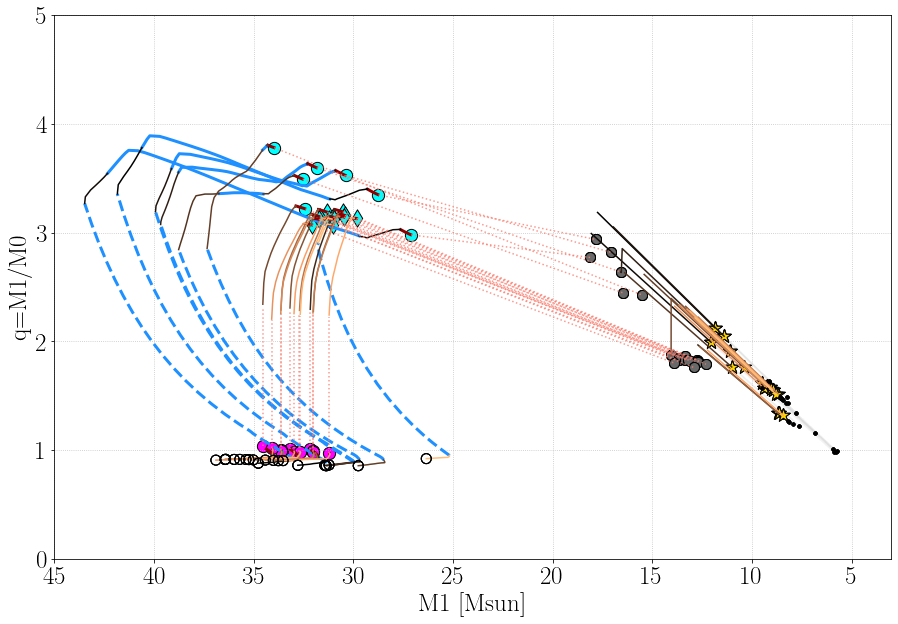

In [25]:
num = 1
if ppisn == 'only':
    xlim = [6.5, 10.5]  #3.5,8.2
    ylim = [0,8]   #1,8
    dfname=r'BHBH_GW_WRBH'
else:
    xlim = [45,3]  #45,20   #45,3 optimistic
    ylim = [0,5] #0,5    #0,10 optimistic
    dfname=r'BHBH_GW_WRBH_cyg_x-3--Ko17'

xaxis = 'Mass_1'
xlabel, ylabel = r'M1 [Msun]', r' q=M1/M0'
fig = plotqcrit( xaxis, num , xlabel, ylabel, xlim,ylim, dfname)
    
plt.show()
fig.savefig(f'{path_results}/{dfname}/qcrit{num}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/qcrit{num}_{dfname}.pdf')

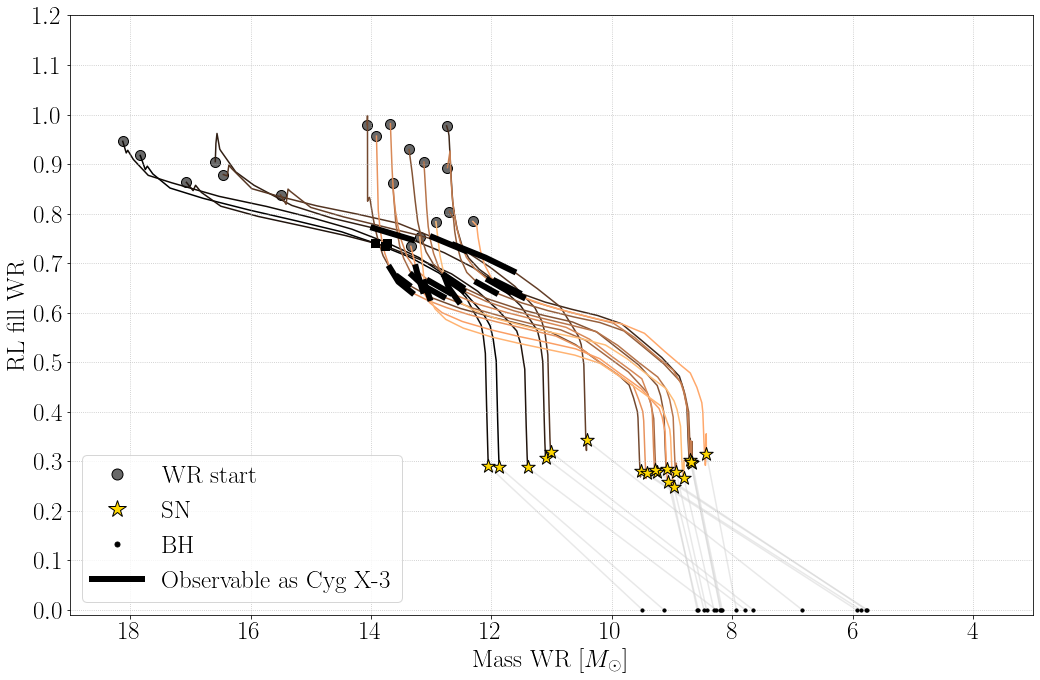

In [26]:
def plotWRBH(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname):
    fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(15,10))
    prog,initial,final,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple
        
    numaccr=1-num  # identify if the accretor is 0 or 1

    for c,name in zip(colors,sortednames):  #10 
        #############################################################
        ######### Extract general infos on the binary ###############
        #############################################################
        #print(name)
        singleout = out[out.name == name]    # all outputs of single binary
        singleRLOstablei = RLOstablei[RLOstablei.name == name]
        singleRLOstablef = RLOstablef[RLOstablef.name == name]
        
        # initial and final values of the mass transfer events
        timesi,timesf = singleRLOstablei.BWorldtime.values,singleRLOstablef.BWorldtime.values
        
        # extract WR first event
        WRcond = singleout[f'PhaseBSE_{num}'].shift().lt(7) & singleout[f'PhaseBSE_{num}'].eq(7) # select 7
        WRevent= singleout[WRcond]
        WReventtime = WRevent.BWorldtime.values[0]
        
        # extract SN event
        SNcond = singleout[f'PhaseBSE_{num}'].shift().ne(14) & singleout[f'PhaseBSE_{num}'].eq(14) # select 14
        preSNcond = singleout[f'PhaseBSE_{num}'].shift(-1).eq(14) & singleout[f'PhaseBSE_{num}'].ne(14)  # before 14
        SNresult = singleout[SNcond] # remnant at the SN explosion
        preSN = singleout[preSNcond]
        SNevent = pd.concat([SNresult,preSN])
        preSNtime = preSN.BWorldtime.values[0]
        
        
        # initial and final values of the WRBH in the selected dfname (e.g. select the cyg x-3 visibility)
        init= initial[initial.name == name]
        fin = final[final.name == name]
        timeinit, timefin = init.BWorldtime.values, fin.BWorldtime.values
        
        # first and last event of all the evolution
        progenitor = singleout.drop_duplicates(subset=['name'], keep='first',ignore_index=True)
        remnant = singleout.drop_duplicates(subset=['name'], keep='last',ignore_index=True)


        ##########################       
        ####### plot  ###########
        #########################
        
        if (yaxis != 'MCO_1') & (yaxis != 'MHE_1'):
            # while in the selected phase
            singleselected= singleout[((singleout.BWorldtime >= timeinit[0]) & (singleout.BWorldtime <= timefin[0]))]
            if len(singleselected.index) == 1:
                singleselected = pd.concat([singleselected,singleselected])
                ax.scatter(singleselected[xaxis].values, singleselected[yaxis].values, c= 'k', marker='s', s=50,zorder=2)
            else:
                ax.plot(singleselected[xaxis].values, singleselected[yaxis].values, color= 'k', linestyle='-', lw=6,zorder=2)
        
        
        
        # other evolutionary phases
        singlepiece= singleout[((singleout.BWorldtime > WReventtime) & (singleout.BWorldtime <= preSNtime))]
        singlepieceWRSN = pd.concat([singlepiece, WRevent]).sort_values(by=['BWorldtime'])
        singlepiecenorem = singlepieceWRSN[singlepieceWRSN[f'PhaseBSE_{num}'] != 14.0]   

        ax.plot(singlepiecenorem[xaxis].values, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)
        

        
#         WR8 = singlepieceWRSN[singlepieceWRSN[f'PhaseBSE_{num}'] == 8.0]
#         ax.plot(WR8[xaxis].values, WR8[yaxis].values, color= 'r', linestyle='solid',zorder=1)

        # SN plot
        ax.plot(SNevent[xaxis].values, SNevent[yaxis].values, color= 'lightgrey', alpha =0.5, linestyle='solid',zorder=1)

        # remnant
        ax.scatter(remnant[xaxis].values,remnant[yaxis].values,facecolors= 'k',
                   edgecolor='k',marker = 'o', s = 10, zorder=4)

        # first WR event
        ax.scatter(WRevent[xaxis].values,WRevent[yaxis].values,c='dimgrey', ec='k',marker = 'o', s=100,zorder=1)

        # SN explosion
        ax.scatter(preSN[xaxis].values,preSN[yaxis].values, c='gold',ec='k',marker = '*', s=200, zorder=2)
        #ax.plot(singleout[xaxis].values, singleout[yaxis].values, color= 'lightgrey', linestyle='solid',zorder=1)

    
    
    ############################################
    ######## refine plot properties ############
    ############################################
    # other settings
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if yaxis == 'RLfill1':
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) # set ticks every 0.1

    
    ax.grid(linestyle='dotted',alpha=0.8)

    ######### legend ###########
    class AnyObjectHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                       linestyle=orig_handle[0], color=orig_handle[1])
            l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                       linestyle=orig_handle[2], color=orig_handle[3])
            return [l1, l2]
    
    p2, = ax.plot([0], [0], 'o', mfc="dimgrey",mec='k',ms=11)
    p3, = ax.plot([0], [0], '*', mfc="gold", mec='k',ms=18)        
    p4, = ax.plot([0], [0], 'o', mfc="k", mec='k',ms=5)
    l1, = ax.plot([0], [0], color = 'k', lw=6)

    
    if ppisn == 'only':
        obslabel = 'WRBH configuration'
        loc = 'upper right'
    else:
        obslabel = 'Observable as Cyg X-3'
        loc = 'lower left'
        
    if yaxis == 'RLfill1':
        ax.legend([p2,p3,p4,l1], ['WR start','SN','BH',obslabel],
                   handler_map={tuple: AnyObjectHandler()}, loc = loc)

    return fig

xaxis, yaxis = 'Mass_1', 'RLfill1'
num = 1
xlabel, ylabel = r' Mass WR [$M_\odot$]', r' RL fill WR'
if ppisn == 'only':
    xlim = [9,2]
    ylim = [-0.01,2.]
    dfname=r'BHBH_GW_WRBH'
else:
    xlim = [19,3]    #19,3
    ylim = [-0.01,1.2]
    dfname='BHBH_GW_WRBH_cyg_x-3--Ko17'
fig = plotWRBH(xaxis, yaxis, num ,xlabel,ylabel,xlim,ylim,dfname)

plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/WR_{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/WR_{xaxis}_{yaxis}_{dfname}.pdf')

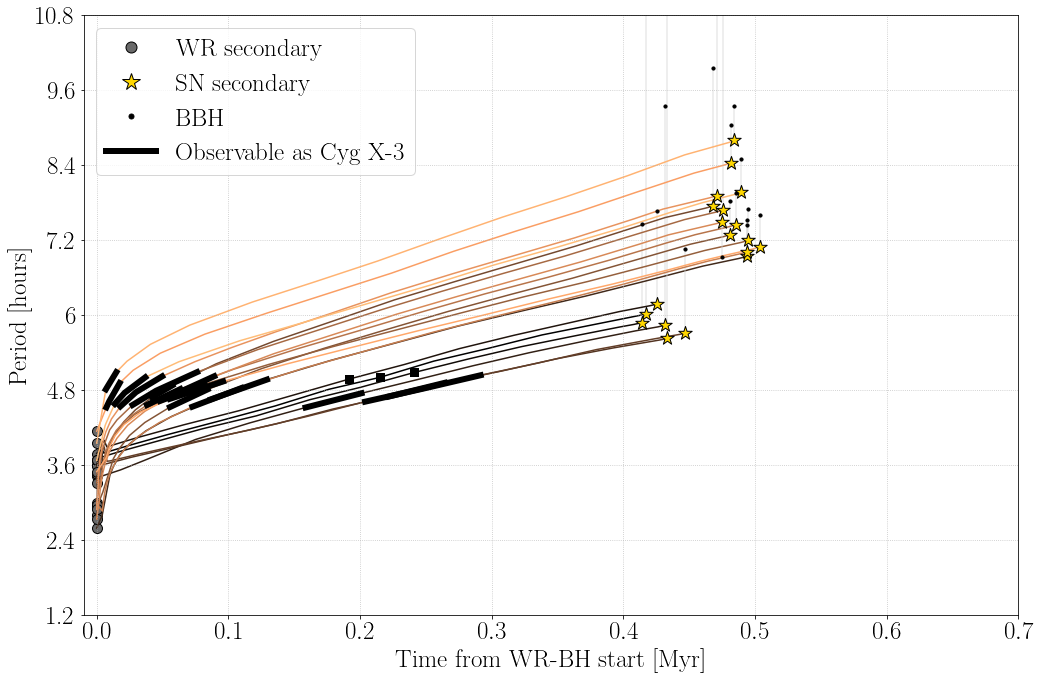

In [27]:
def plotWRBHper(xaxis,yaxis, num, xlabel, ylabel, xlim,ylim, dfname):
    fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(15,10))
    prog,initial,final,rem = Extract(dfname)
    out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname)
    phasebse = f'PhaseBSE_{num}'
    sortednames = prog.sort_values(by='a')['name'].values
    
    NUM_COLORS = len(sortednames)
    cm = plt.get_cmap('copper')
    colors=[]
    for i in range(NUM_COLORS):
        colors.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple
        
    
#     # set colors of lines as tracer for the primary BH mass
#     BH0masses = rem.Mass_0.values
#     BH0max, BH0min = BH0masses.max(), BH0masses.min()
#     minvalue = BH0min - 0.5
    
#     cm = plt.get_cmap('gist_gray_r')
#     color_list=[]
#     for BH0mass in BH0masses:
#         fraction = (BH0mass - minvalue) / (BH0max-minvalue)  # "occupation fraction" of the BH in the considered range
#         color_list.append(cm(1.*fraction))  # color will now be an RGBA tuple


        

    #for name,color in zip(RLOrecap.name.values,color_list):  #10 
    for c,name in zip(colors,sortednames):  #10 
        #############################################################
        ######### Extract general infos on the binary ###############
        #############################################################
        #print(name)
        singleout = out[out.name == name]    # all outputs of single binary
        singleRLOstablei = RLOstablei[RLOstablei.name == name]
        singleRLOstablef = RLOstablef[RLOstablef.name == name]
        
        # initial and final values of the mass transfer events
        timesi,timesf = singleRLOstablei.BWorldtime.values,singleRLOstablef.BWorldtime.values
        
        # extract WR first event
        WRcond = singleout[f'PhaseBSE_{num}'].shift().lt(7) & singleout[f'PhaseBSE_{num}'].eq(7) # select 7
        WRevent= singleout[WRcond]
        WReventtime = WRevent.BWorldtime.values[0]
        
        # extract SN event
        SNcond = singleout[f'PhaseBSE_{num}'].shift().ne(14) & singleout[f'PhaseBSE_{num}'].eq(14) # select 14
        preSNcond = singleout[f'PhaseBSE_{num}'].shift(-1).eq(14) & singleout[f'PhaseBSE_{num}'].ne(14)  # before 14
        SNresult = singleout[SNcond] # remnant at the SN explosion
        preSN = singleout[preSNcond]
        SNevent = pd.concat([SNresult,preSN])
        preSNtime = preSN.BWorldtime.values[0]
        
        
        # initial and final values of the WRBH in the selected dfname (e.g. select the cyg x-3 visibility)
        init= initial[initial.name == name]
        fin = final[final.name == name]
        timeinit, timefin = init.BWorldtime.values, fin.BWorldtime.values
        
        # first and last event of all the evolution
        progenitor = singleout.drop_duplicates(subset=['name'], keep='first',ignore_index=True)
        remnant = singleout.drop_duplicates(subset=['name'], keep='last',ignore_index=True)


        ##########################       
        ####### plot  ###########
        #########################
        

        # while in the selected phase
        singleselected= singleout[((singleout.BWorldtime >= timeinit[0]) & (singleout.BWorldtime <= timefin[0]))]
        if len(singleselected.index) == 1:
            singleselected = pd.concat([singleselected,singleselected])
            ax.scatter(singleselected[xaxis].values-WReventtime, singleselected[yaxis].values, c= 'k', marker='s', s=50,zorder=2)
        else:
            ax.plot(singleselected[xaxis].values-WReventtime, singleselected[yaxis].values, color= 'k', linestyle='-', lw=6,zorder=2)

        
        # other evolutionary phases
        singlepiece= singleout[((singleout.BWorldtime > WReventtime) & (singleout.BWorldtime <= preSNtime))]
        singlepieceWRSN = pd.concat([singlepiece, WRevent]).sort_values(by=['BWorldtime'])
        singlepiecenorem = singlepieceWRSN[singlepieceWRSN[f'PhaseBSE_{num}'] != 14.0]    
        
        ax.plot(singlepiecenorem[xaxis].values-WReventtime, singlepiecenorem[yaxis].values, color= c, linestyle='solid',zorder=1)

        
#         if len(timesi) >0: # if goes through at least one stable RLO
#             ax.plot(singlepiecenorem[xaxis].values-WReventtime, singlepiecenorem[yaxis].values, color= 'k', linestyle='solid',zorder=1)
#         else:
#             ax.plot(singlepiecenorem[xaxis].values-WReventtime, singlepiecenorem[yaxis].values, color= 'darkgrey', linestyle='solid',zorder=1)
     
       # SN plot
        ax.plot(SNevent[xaxis].values-WReventtime, SNevent[yaxis].values, color= 'lightgrey', alpha =0.5, linestyle='solid',zorder=1)

        # remnant
        ax.scatter(remnant[xaxis].values-WReventtime,remnant[yaxis].values,facecolors= 'k',
                   edgecolor='k',marker = 'o', s = 10, zorder=4)

        # first WR event
        ax.scatter(WRevent[xaxis].values-WReventtime,WRevent[yaxis].values,c='dimgrey', ec='k',marker = 'o', s=100,zorder=1)

        # SN explosion
        ax.scatter(preSN[xaxis].values-WReventtime,preSN[yaxis].values, c='gold',ec='k',marker = '*', s=200, zorder=3)
        #ax.plot(singleout[xaxis].values, singleout[yaxis].values, color= 'lightgrey', linestyle='solid',zorder=1)

    
    
    ############################################
    ######## refine plot properties ############
    ############################################
    # other settings
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # convert y ticks from days to hours
    if yaxis == 'Period':
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*24.))
        ax.yaxis.set_major_formatter(ticks_y)

    
    ax.grid(linestyle='dotted',alpha=0.8)

    ######### legend ###########
    class AnyObjectHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,
                           x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                       linestyle=orig_handle[0], color=orig_handle[1])
            l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                       linestyle=orig_handle[2], color=orig_handle[3])
            return [l1, l2]
    
    p2, = ax.plot([0], [0], 'o', mfc="dimgrey",mec='k',ms=11)
    p3, = ax.plot([0], [0], '*', mfc="gold", mec='k',ms=18)        
    p4, = ax.plot([0], [0], 'o', mfc="k", mec='k',ms=5)
    l1, = ax.plot([0], [0], color = 'k', lw=6)
    
    
       
    ax.legend([p2,p3,p4,l1], ['WR secondary','SN secondary','BBH', 'Observable as Cyg X-3'],
               handler_map={tuple: AnyObjectHandler()}, loc = 'upper left')

#     # add colorbar
#     norm = colors.Normalize(vmin=minvalue,vmax=BH0max)
#     sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
#     sm.set_array([])
#     plt.colorbar(sm, boundaries=np.arange(np.round(BH0min),np.round(BH0max),.5), label=r'$M_{\rm BH, primary}$ [$M_\odot$]')
    return fig



xaxis, yaxis = 'BWorldtime', 'Period'
num = 1
# xlim = [-0.01,0.7]
# ylim = [0.05,0.5]

if ppisn == 'only':
    dfname=r'BHBH_GW_WRBH'
    xlim = [-0.01,1]
    ylim = [0.00005,1.5]
else:
    xlim = [-0.01,0.7]
    ylim = [0.05,0.45]
    dfname='BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r' Time from WR-BH start [Myr]', r' Period [hours]'
fig = plotWRBHper(xaxis, yaxis, num ,xlabel,ylabel,xlim,ylim,dfname)

plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

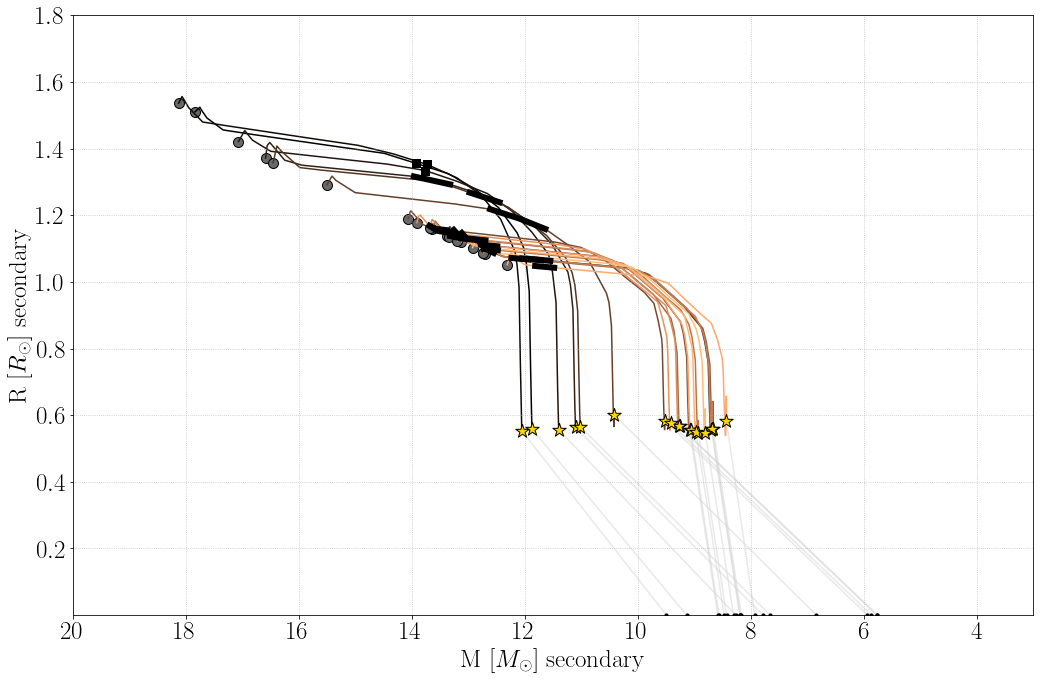

In [28]:
xaxis, yaxis = 'Mass_1', 'Radius_1'
num = 1
# xlim = [10.5,4.]
# ylim = [0.3,1.9]

if ppisn == 'only':
    xlim = [9,2.]
    ylim = [0.001,3.5]
    dfname=r'BHBH_GW_WRBH'
else:
    xlim = [20,3.]
    ylim = [0.001,1.8]
    dfname='BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r'M [$M_\odot$] secondary', r' R [$R_\odot$] secondary'
fig = plotWRBH(xaxis, yaxis, num ,xlabel,ylabel,xlim,ylim,dfname)
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

In [29]:
# xaxis, yaxis = 'BWorldtime', 'RL1'
# num = 1
# xlim = [4.8,7.3]
# ylim = [1,2.3]
# xlabel, ylabel = r'Time from ZAMS [Myr]', r' RL [$R_\odot$] secondary'
# dfname='BHBH_GW_WRBH_cyg_x-3--Ko17'
# fig = plotWRBH(xaxis, yaxis, num ,xlabel,ylabel,xlim,ylim,dfname)
# plt.tight_layout()
# plt.show()

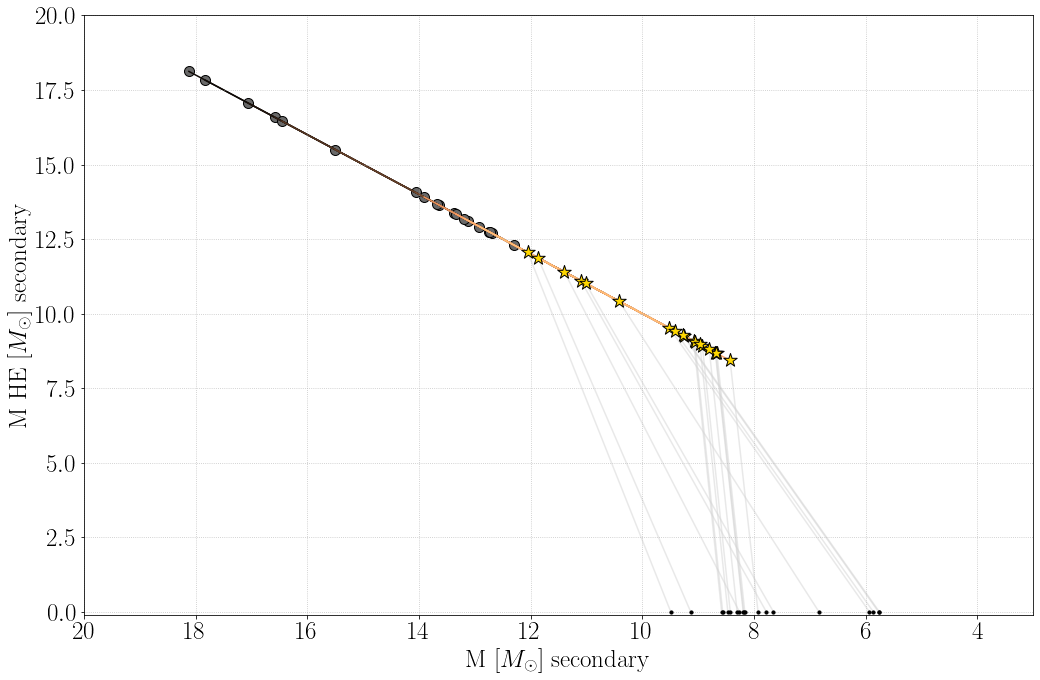

In [30]:
xaxis, yaxis = 'Mass_1', 'MHE_1'
num = 1
if ppisn == 'only':
    xlim = [9,2]
    ylim = [-0.1,9]
    dfname='BHBH_GW_WRBH'
else:
    xlim = [20,3]
    ylim = [-0.1,20]
    dfname='BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r'M [$M_\odot$] secondary', r' M HE [$M_\odot$] secondary'
fig = plotWRBH(xaxis, yaxis, num ,xlabel,ylabel,xlim,ylim,dfname)
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

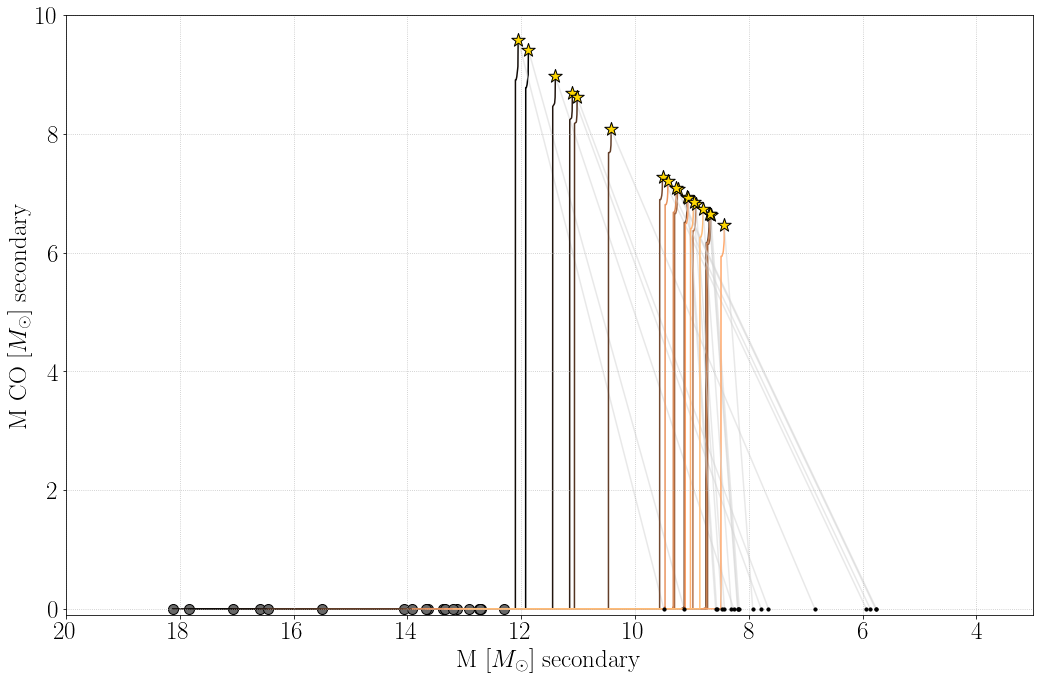

In [31]:
xaxis, yaxis = 'Mass_1', 'MCO_1'
num = 1
if ppisn == 'only':
    xlim = [9,2]
    ylim = [-0.1,4]
    dfname='BHBH_GW_WRBH'
else:
    xlim = [20,3]
    ylim = [-0.1,10]
    dfname='BHBH_GW_WRBH_cyg_x-3--Ko17'
xlabel, ylabel = r'M [$M_\odot$] secondary', r' M CO [$M_\odot$] secondary'
fig = plotWRBH(xaxis, yaxis, num ,xlabel,ylabel,xlim,ylim,dfname)
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.jpg')
fig.savefig(f'{path_results}/{dfname}/{xaxis}_{yaxis}_{dfname}.pdf')

# Hist2d plots

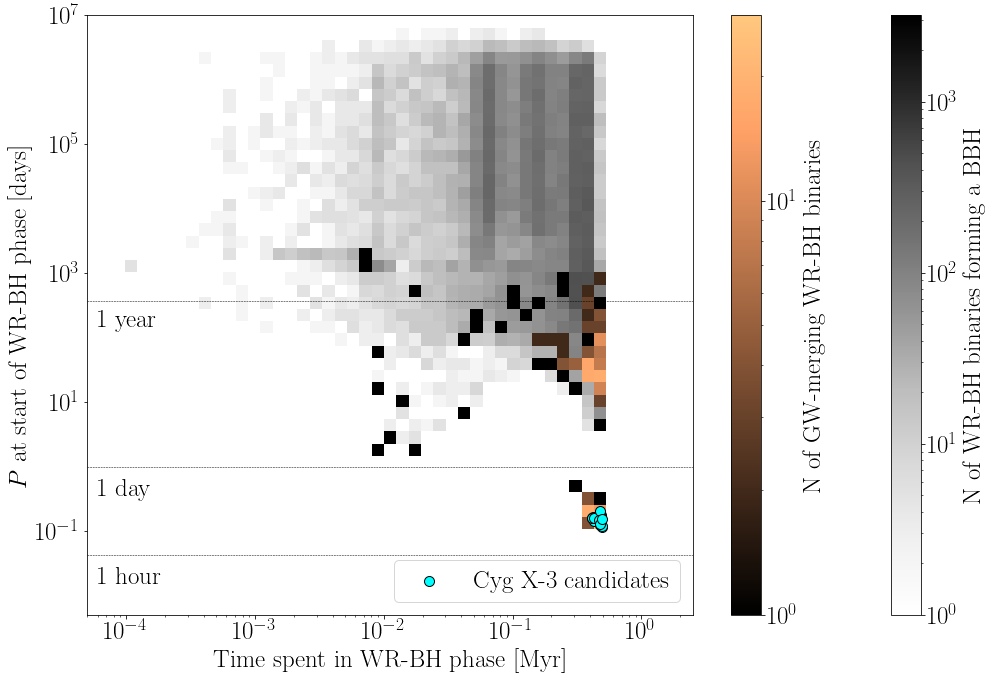

In [32]:
xedges = np.logspace(np.log10(5e-5),np.log10(2.50), 50)
yedges = np.logspace(np.log10(5e-3),np.log10(1e7), 50)

fig = plt.figure(figsize=(15,10))
h1 = plt.hist2d(delta_ifall.BWorldtime.values, iall.Period.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm())
h2 = plt.hist2d(delta_if.BWorldtime.values, i.Period.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm())
plt.axhline(365,linestyle='dashed',lw=0.5,color='k')
plt.axhline(1,linestyle='dashed',lw=0.5,color='k')
plt.axhline(1./24.,linestyle='dashed',lw=0.5,color='k')
plt.annotate('1 year',xy=(6e-5,150))
plt.annotate('1 day',xy=(6e-5,0.35))
plt.annotate('1 hour',xy=(6e-5,0.015))
plt.xlabel(r'Time spent in WR-BH phase [Myr]')
plt.ylabel(r'$P$ at start of WR-BH phase [days]')
plt.xscale('log')
plt.yscale('log')
fig.colorbar(h1[3], label='N of WR-BH binaries forming a BBH')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries')
if ppisn != 'only':
    plt.scatter(delta_if_if2.BWorldtime.values, i_i2.Period.values,color='cyan',edgecolor='k',s=100, label='Cyg X-3 candidates')
    plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/PvsTime{dfname1}_{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/PvsTime{dfname1}_{dfname2}.pdf')

In [33]:
# third Kepler law
def KeplerA(M1,M2,P):
    # conversions
    Rsun = float(7e8)  #m   700 000 km
    Msun = float(2e30) #kg

    G = float(6.67e-11) #mks
    G4pi2 = float(G/(4*np.pi*np.pi))  # G/4*pi^2
    
    years = 60*60*24*365 # seconds in a year
    
    # convert everything into the mks systems because
    # M1, M2 are given in Msun
    # P is given in yrs as input
    M1mks = M1 * Msun
    M2mks = M2 * Msun
    Pmks = P * years
    
    # a^3/P^2 = (M1+M2)*G/4*pi^2
    amks = (Pmks*Pmks * (M1mks+M2mks)*G4pi2)**(1./3.)
    a = amks / Rsun  # Semimajor in Rsun
    return a

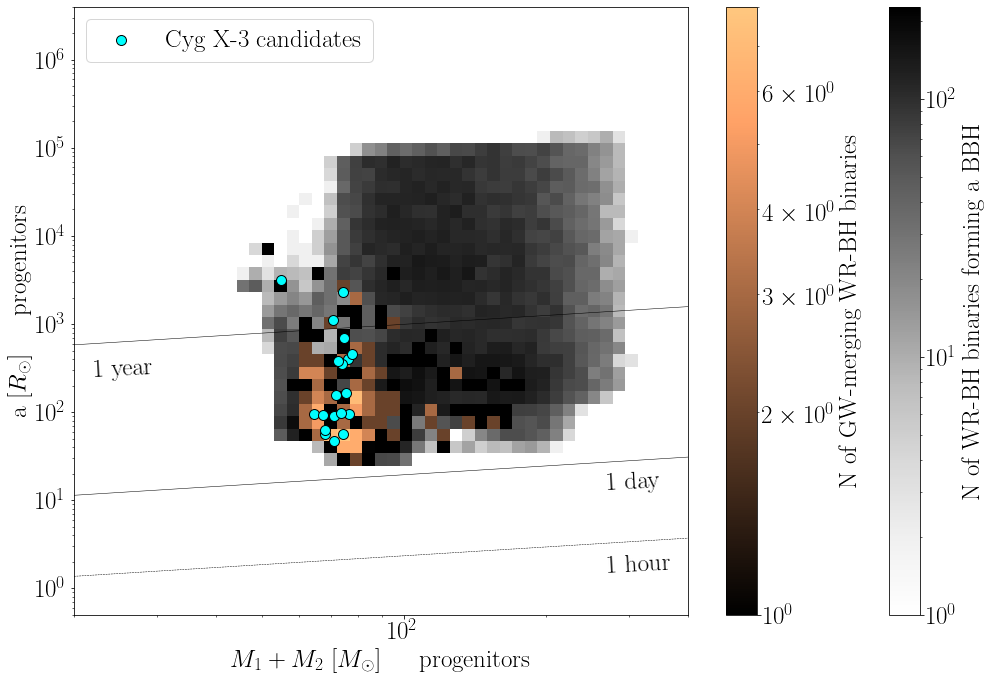

In [34]:
# beginning of the WRBH phase (not the cyg one)
fig = plt.figure(figsize=(15,10))
xmin,xmax = 20,400
x = np.linspace(xmin,xmax,1)
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)

counts, xedg,yedg = np.histogram2d(pall.Mass_0.values + pall.Mass_1.values, pall.a.values, bins= [xedges,yedges])
h1 = plt.hist2d(pall.Mass_0.values + pall.Mass_1.values, pall.a.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm())
counts2, xedg,yedg = np.histogram2d(p.Mass_0.values + p.Mass_1.values, p.a.values, bins= [xedges,yedges])
h2 = plt.hist2d(p.Mass_0.values + p.Mass_1.values, p.a.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm())


plt.plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
plt.plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
plt.plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='dashed',lw=0.5) # 1 hour
plt.annotate('1 year',xy=(22,250),rotation=3)
plt.annotate('1 day',xy=(270,13),rotation=3)
plt.annotate('1 hour',xy=(270,1.5),rotation=3)

plt.xlabel(r'$M_{\rm 1} + M_{\rm 2}$ [$M_\odot$] $\quad$  progenitors')
plt.ylabel(r'a [$R_\odot$] $\quad$ progenitors')
plt.xscale('log')
plt.yscale('log')
fig.colorbar(h1[3], label='N of WR-BH binaries forming a BBH')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries')
if ppisn!='only':
    plt.scatter(p2.Mass_0.values + p2.Mass_1.values, p2.a.values,color='cyan',ec='k',s=100, label='Cyg X-3 candidates')
    plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/avsMtotPROG{dfname1}_{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/avsMtotPROG{dfname1}_{dfname2}.pdf')

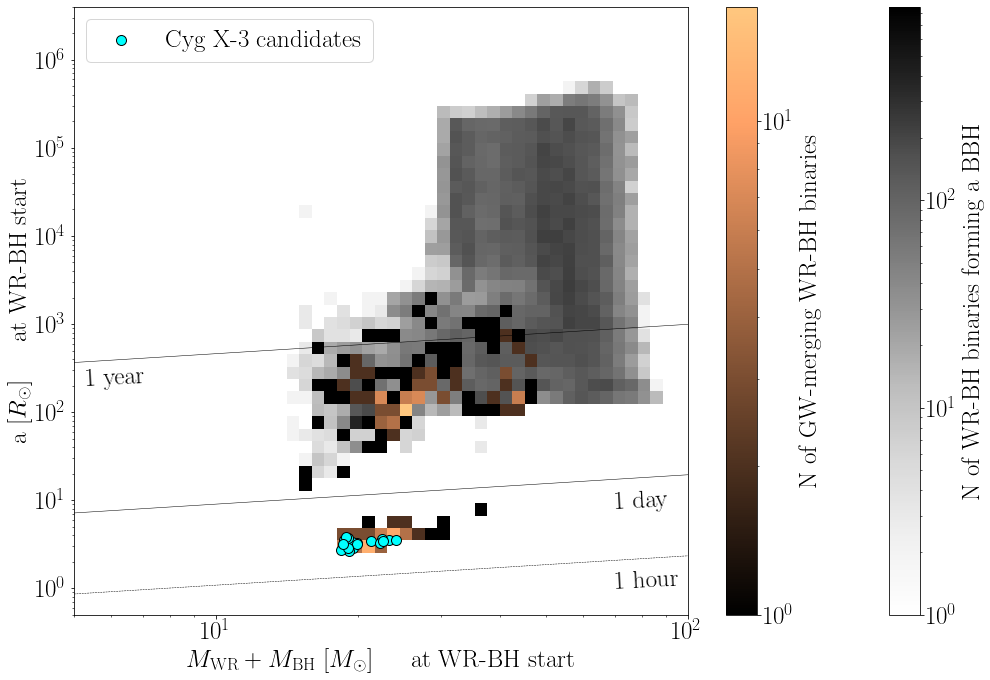

In [35]:
# beginning of the WRBH phase (not the cyg one)
fig = plt.figure(figsize=(15,10))
xmin,xmax = 5,1e2
x = np.linspace(xmin,xmax,1)
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)

counts, xedg,yedg = np.histogram2d(iall.Mass_0.values + iall.Mass_1.values, iall.Semimajor.values, bins= [xedges,yedges])
h1 = plt.hist2d(iall.Mass_0.values + iall.Mass_1.values, iall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm())
counts2, xedg,yedg = np.histogram2d(i.Mass_0.values + i.Mass_1.values, i.Semimajor.values, bins= [xedges,yedges])
h2 = plt.hist2d(i.Mass_0.values + i.Mass_1.values, i.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm())


plt.plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 day
plt.plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
plt.plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='dashed',lw=0.5) # 1 day
plt.annotate('1 year',xy=(5.3,200),rotation=3)
plt.annotate('1 day',xy=(70,8),rotation=3)
plt.annotate('1 hour',xy=(70,1),rotation=3)

plt.xlabel(r'$M_{\rm WR} + M_{\rm BH}$ [$M_\odot$] $\quad$  at WR-BH start')
plt.ylabel(r'a [$R_\odot$] $\quad$ at WR-BH start')
plt.xscale('log')
plt.yscale('log')
fig.colorbar(h1[3], label='N of WR-BH binaries forming a BBH')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries')
if ppisn!='only':
    plt.scatter(i_i2.Mass_0.values + i_i2.Mass_1.values, i_i2.Semimajor.values,color='cyan',ec='k',s=100, label='Cyg X-3 candidates')
    plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/avsMtot{dfname1}_{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/avsMtot{dfname1}_{dfname2}.pdf')

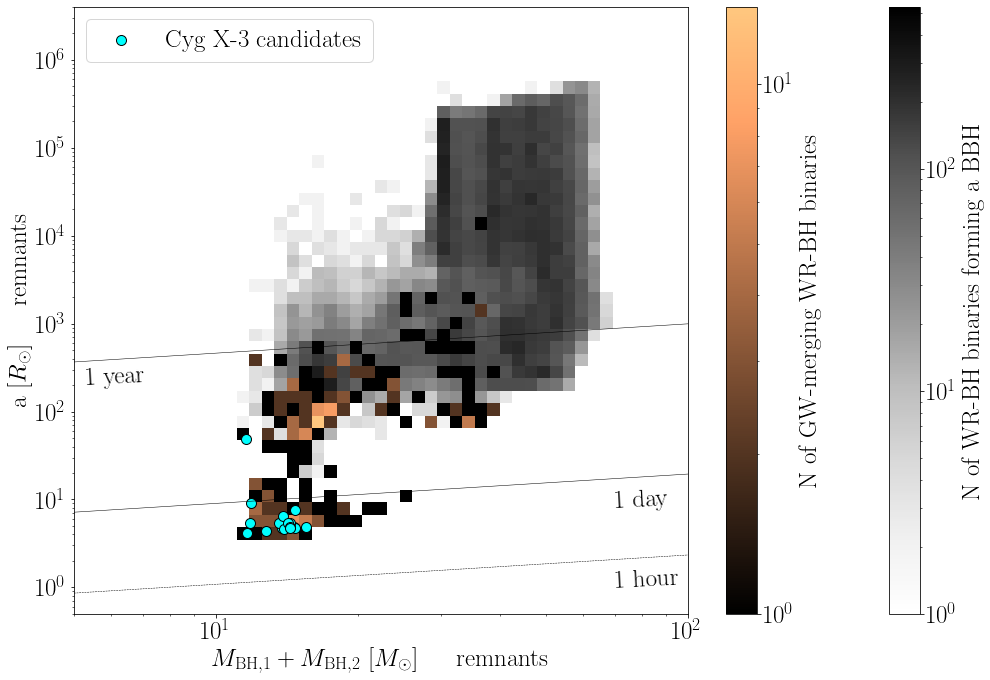

In [36]:
# beginning of the WRBH phase (not the cyg one)
fig = plt.figure(figsize=(15,10))
xmin,xmax = 5,100
x = np.linspace(xmin,xmax,1)
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)

counts, xedg,yedg = np.histogram2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins= [xedges,yedges])
h1 = plt.hist2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm())
counts2, xedg,yedg = np.histogram2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins= [xedges,yedges])
h2 = plt.hist2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm())


plt.plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
plt.plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
plt.plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='dashed',lw=0.5) # 1 hour
plt.annotate('1 year',xy=(5.3,200),rotation=3)
plt.annotate('1 day',xy=(70,8),rotation=3)
plt.annotate('1 hour',xy=(70,1),rotation=3)

plt.xlabel(r'$M_{\rm BH, 1} + M_{\rm BH,2}$ [$M_\odot$] $\quad$  remnants')
plt.ylabel(r'a [$R_\odot$] $\quad$ remnants')
plt.xscale('log')
plt.yscale('log')
fig.colorbar(h1[3], label='N of WR-BH binaries forming a BBH')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries')
if ppisn!='only':
    plt.scatter(r2.Mass_0.values + r2.Mass_1.values, r2.Semimajor.values,color='cyan',ec='k',s=100, label='Cyg X-3 candidates')
    plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/avsMtotREM{dfname1}_{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/avsMtotREM{dfname1}_{dfname2}.pdf')

In [37]:
# # third Kepler law
# def KeplerP(M1,M2,a):
#     # conversions
#     Rsun = float(7e8)  #m   700 000 km
#     Msun = float(2e30) #kg

#     G = float(6.67e-11) #mks
#     G4pi2 = float(G/(4*np.pi*np.pi))  # G/4*pi^2
    
#     days = 60*60*24 # seconds in a day
    
    
#     # M1, M2 are given in Msun
#     # a is given in Rsun
#     M1mks = M1 * Msun
#     M2mks = M2 * Msun
#     amks = a * Rsun
    
#     # a^3/P^2 = (M1+M2)*G/4*pi^2
#     Pmks = np.sqrt(amks*amks*amks / (G4pi2*(M1mks + M2mks)))
#     Pdays = Pmks / days
#     return Pdays

In [38]:
# # beginning of the WRBH phase (not the cyg one)
# fig = plt.figure(figsize=(15,10))
# xedges = np.logspace(np.log10(1e-1),np.log10(14000), 40)
# yedges = np.logspace(np.log10(1e-2),np.log10(1e1), 40)

# h2 = plt.hist2d(r.GWtime.values , i.Period.values, bins=(xedges,yedges), cmap='inferno', cmin=1,norm=colors.Normalize())
# plt.scatter(r2.GWtime.values , i_i2.Period.values,color='cyan',ec='k',s=200, label='Cyg X-3 candidates')
# plt.axhline(1,linestyle='dashed',lw=0.5,color='k')
# plt.axhline(1./24.,linestyle='dashdot',lw=0.5,color='k')
# plt.annotate('1 day',xy=(0.15,0.7))
# plt.annotate('1 hour',xy=(0.15,0.03))
# plt.xlabel(r'Time to merge as BBH [Myr]')
# plt.ylabel(r'$P$ at start of WR-BH phase [days]')
# plt.xscale('log')
# plt.yscale('log')
# fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries')
# plt.legend(loc='upper left')
# plt.grid(linestyle='dotted',alpha=0.8)
# plt.tight_layout()
# plt.show()
# fig.savefig(f'{path_results}/{dfname2}/PvsGWtime{dfname2}')

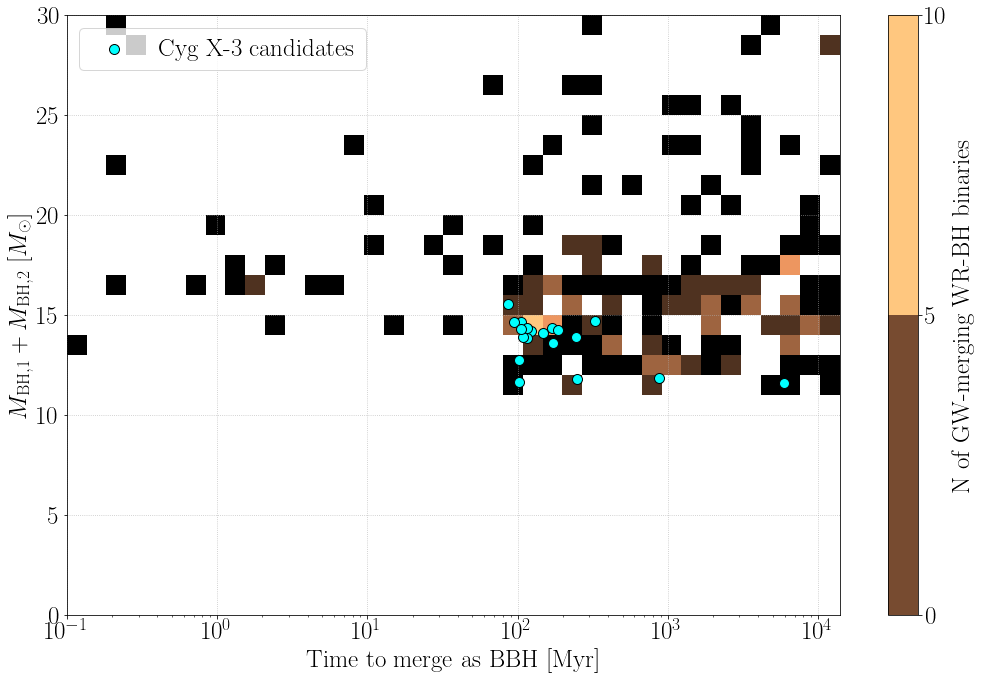

In [39]:
# beginning of the WRBH phase (not the cyg one)
fig = plt.figure(figsize=(15,10))
xmin,xmax,Nxbins = 1e-1,14000,40
ymin,ymax,Nybins = 0,30,31

xedges = np.logspace(np.log10(xmin),np.log10(xmax), Nxbins)
yedges = np.linspace(ymin,ymax,Nybins)

counts, xedg,yedg = np.histogram2d(r.GWtime.values , r.Mass_0.values+r.Mass_1.values, bins= [xedges,yedges])
h2 = plt.hist2d(r.GWtime.values , r.Mass_0.values+r.Mass_1.values, bins=(xedges,yedges), cmap='copper', cmin=1,norm=colors.Normalize())
plt.xlabel(r'Time to merge as BBH [Myr]')
plt.ylabel(r'$M_{\rm BH,1} + M_{\rm BH,2}$ [$M_\odot$]')
plt.xscale('log')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries',boundaries=np.arange(0,counts.max()+6,5))

if ppisn != 'only':
    plt.scatter(r2.GWtime.values , r2.Mass_0.values+r2.Mass_1.values,color='cyan',ec='k',s=100,zorder=2, label='Cyg X-3 candidates')
    plt.legend(loc = 'upper left')

plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/MtotBHvsGWtime{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/MtotBHvsGWtime{dfname2}.pdf')

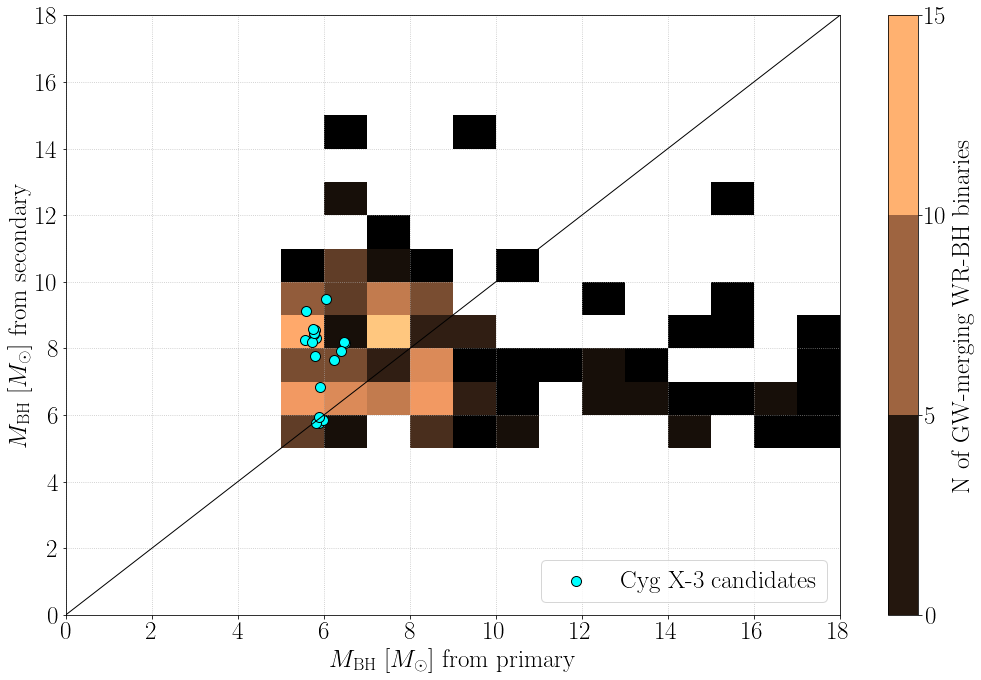

In [40]:
# beginning of the WRBH phase (not the cyg one)
fig = plt.figure(figsize=(15,10))
maxvalue = 18
xedges = np.linspace(0,maxvalue,maxvalue+1)
yedges = np.linspace(0,maxvalue,maxvalue+1)

counts, xedg,yedg = np.histogram2d(r.Mass_0.values , r.Mass_1.values,  bins= [xedges,yedges])
h2 = plt.hist2d(r.Mass_0.values , r.Mass_1.values, bins=(xedges,yedges), cmap='copper', cmin=1,norm = colors.Normalize(vmin=1))
plt.plot([0,maxvalue],[0,maxvalue],color='k', lw=1)
if ppisn == 'only':
    plt.axvline(3, color='k',linestyle='dotted')
    plt.axhline(3, color='k',linestyle='dotted')


plt.xlabel(r'$M_{\rm BH}$ [$M_\odot$] from primary ')
plt.ylabel(r'$M_{\rm BH}$ [$M_\odot$] from secondary ')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries',boundaries=np.arange(0,counts.max()+6,5))
if ppisn != 'only':
    plt.scatter(r2.Mass_0.values , r2.Mass_1.values,color='cyan',ec='k',s=100,zorder=2, label='Cyg X-3 candidates')
    plt.legend(loc = 'lower right')
    

plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/MBH1vsMBH2{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/MBH1vsMBH2{dfname2}.pdf')

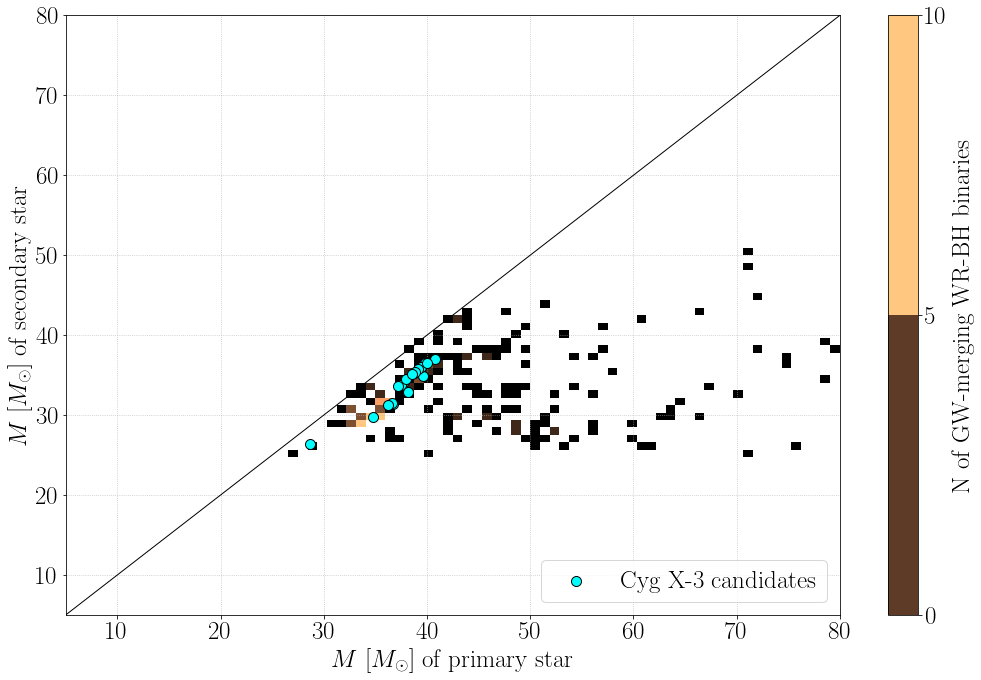

In [41]:
# beginning of the WRBH phase (not the cyg one)
fig = plt.figure(figsize=(15,10))
minvalue, maxvalue = 5,80   # optimistic case
#minvalue, maxvalue = 15,80   # 15,60
xedges = np.linspace(minvalue,maxvalue,maxvalue+1)
yedges = np.linspace(minvalue,maxvalue,maxvalue+1)

counts, xedg,yedg = np.histogram2d(p.Mass_0.values , p.Mass_1.values,  bins= [xedges,yedges])

h2 = plt.hist2d(p.Mass_0.values , p.Mass_1.values, bins=(xedges,yedges), cmap='copper', cmin=1,norm = colors.Normalize(vmin=1))
plt.plot([minvalue,maxvalue],[minvalue,maxvalue],color='k', lw=1)

plt.xlabel(r'$M$ [$M_\odot$] of primary star')
plt.ylabel(r'$M$ [$M_\odot$] of secondary star')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries',boundaries=np.arange(0,counts.max()+6,5))

if ppisn != 'only':
    plt.scatter(p2.Mass_0.values , p2.Mass_1.values,color='cyan',ec='k',s=100,zorder=2, label='Cyg X-3 candidates')
    plt.legend(loc = 'lower right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/Mp1vsMp2{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/Mp1vsMp2{dfname2}.pdf')

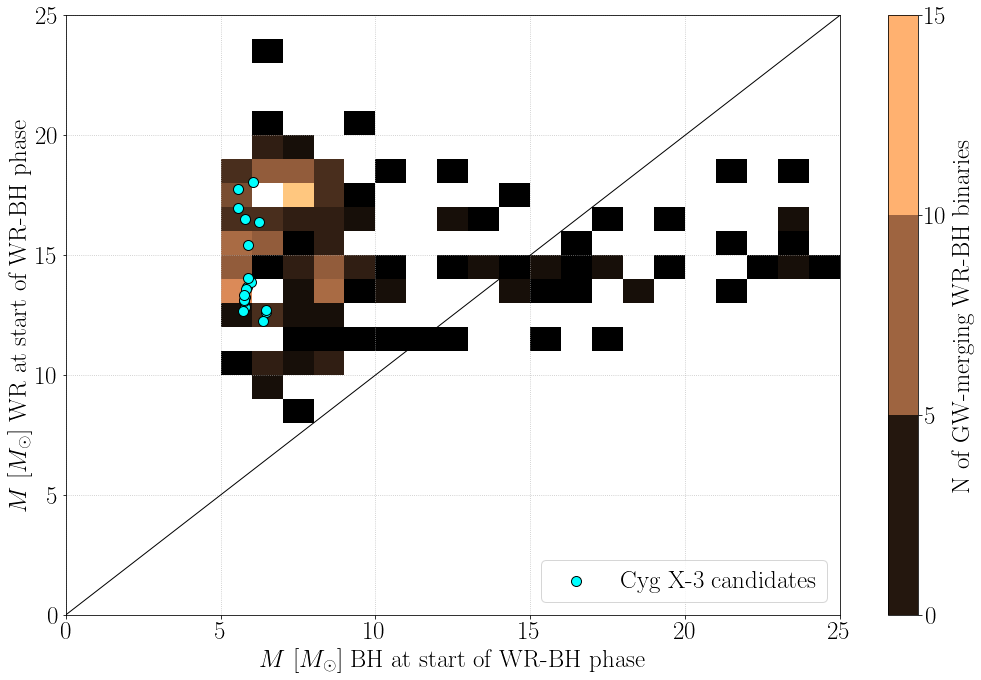

In [42]:
# beginning of the WRBH phase (not the cyg one)
fig = plt.figure(figsize=(15,10))
minvalue, maxvalue = 0,25
xedges = np.linspace(minvalue,maxvalue,maxvalue+1)
yedges = np.linspace(minvalue,maxvalue,maxvalue+1)

counts, xedg,yedg = np.histogram2d(i.Mass_0.values , i.Mass_1.values, bins= [xedges,yedges])
h2 = plt.hist2d(i.Mass_0.values , i.Mass_1.values, bins=(xedges,yedges), cmap='copper', cmin=1,norm = colors.Normalize(vmin=1))
plt.plot([minvalue,maxvalue],[minvalue,maxvalue],color='k', lw=1)
if ppisn == 'only':
    plt.axvline(3, color='k',linestyle='dotted')
    plt.axhline(3, color='k',linestyle='dotted')

plt.xlabel(r'$M$ [$M_\odot$] BH at start of WR-BH phase')
plt.ylabel(r'$M$ [$M_\odot$] WR at start of WR-BH phase')
fig.colorbar(h2[3], label='N of GW-merging WR-BH binaries',boundaries=np.arange(0,counts.max()+6,5))
if ppisn!= 'only':
    plt.scatter(i_i2.Mass_0.values , i_i2.Mass_1.values,color='cyan',ec='k',s=100, label='Cyg X-3 candidates')
    plt.legend(loc = 'lower right')
plt.grid(linestyle='dotted',alpha=0.8)
plt.tight_layout()
plt.show()
fig.savefig(f'{path_results}/{dfname}/Mi1vsMi2{dfname2}.jpg')
fig.savefig(f'{path_results}/{dfname}/Mi1vsMi2{dfname2}.pdf')

# other

In [43]:
# # same plot but only for binaries visible as cyg x-3, while they are visible as cyg x-3
# plt.scatter(i2.Mass_0.values+i2.Mass_1.values, i2.Period.values*24, color='r')
# #plt.hist2d(delta_if_if2.BWorldtime.values, i_i2.Period.values, bins=(50,50), range=[[0,2],[0,100]], cmin=1, cmap='Reds')
# plt.xlabel(r'M0 + M1 initial Cyg X-3 [Myr]')
# plt.ylabel(r'P initial Cyg X-3 [hours]')
# plt.show()

In [44]:
# # same plot but only for binaries visible as cyg x-3, while they are visible as cyg x-3
# # here I am asking: when I see the cyg x-3 binary, 
# # how much time elapsed from its formation and how much time is left until the BBH formation?
# plt.scatter(i2.BWorldtime.values, delta_if_if2.BWorldtime.values, color='r')
# #plt.hist2d(delta_if_if2.BWorldtime.values, i_i2.Period.values, bins=(50,50), range=[[0,2],[0,100]], cmin=1, cmap='Reds')
# plt.xlabel(r'Time from ZAMS to Cyg X-3 [Myr]')
# plt.ylabel(r'Time from Cyg X-3 to BBH')
# plt.show()

In [45]:
# # time visible as cyg x-3 with today parameters / time as WRBH
# time_frac_2 = 100 * (delta_if2.BWorldtime.values / delta_if_if2.BWorldtime.values)  # percentage of time spent as visible
# plt.scatter(i_i2.Period*24, time_frac_2)
# plt.xlabel(r'$P_{\rm initial}$ [days]')
# plt.ylabel(r'% time spent in Cyg X-3 phase w.r.t. WRBH phase')
# plt.show()

In [46]:
def Distributions(data,Nbins):
    # getting data of the histogram
    count, bins_count = np.histogram(data, bins=Nbins)

    # finding the PDF of the histogram using count values
    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    
    return pdf,cdf,bins_count

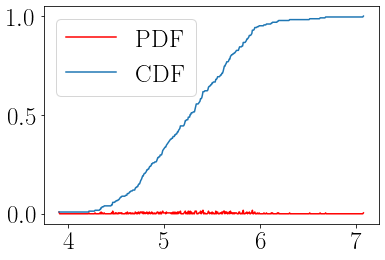

In [47]:
pdf,cdf,bins_count = Distributions(i['BWorldtime'],Nbins=500)

# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()

In [48]:
i1

NameError: name 'i1' is not defined

In [ ]:
pdf1,cdf1,bins_count1 = Distributions(i1['BWorldtime'],Nbins=10)

# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.plot(bins_count1[1:], pdf1, color="red", label="PDF1")
plt.plot(bins_count1[1:], cdf1, label="CDF1")
plt.legend()
plt.show()

In [ ]:
plt.hist(i['BWorldtime'], bins=np.arange(0,20,0.1), density=True,  histtype='step')
plt.hist(i1['BWorldtime'], bins=np.arange(0,20,0.1), density=True,  histtype='step')
plt.show()

In [ ]:
plt.hist(delta_if['BWorldtime'], bins=np.arange(0,2,0.05), log=True,  histtype='step')
plt.show()